# <h1 style= 'background: #C29389; border:2; color:white; padding-top:10px'><center><b>Most Runs in Cricket</b></center></h1>

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")
palette = ["#C29389"]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/most-runs-in-cricket/most_runs_in_cricket.csv


In [2]:
df = pd.read_csv("/kaggle/input/most-runs-in-cricket/most_runs_in_cricket.csv")
df.head()

Unnamed: 0                       Player       Span  Mat  Inns  NO   Runs  \
0           0         SR Tendulkar (INDIA)  1989-2013  664   782  74  34357   
1           1  KC Sangakkara (Asia/ICC/SL)  2000-2015  594   666  67  28016   
2           2         RT Ponting (AUS/ICC)  1995-2012  560   668  70  27483   
3           3   DPMD Jayawardene (Asia/SL)  1997-2015  652   725  62  25957   
4           4       JH Kallis (Afr/ICC/SA)  1995-2014  519   617  97  25534   

    HS    Ave      BF     SR  100   50   0    4s   6s  
0  248  48.52  50817+  67.58  100  164  34  4076  264  
1  319  46.77   42086  66.56   63  153  28  3015  159  
2  257  45.95   40130  68.48   71  146  39  2781  246  
3  374  39.15   40100  64.73   54  136  47  2679  170  
4  224  49.10   45346  56.30   62  149  33  2455  254

# <h1 style='background:#C29389; border:0; color:white; padding-top:10px'><center><b>Exploratory Data Analysis</b></center></h1> 

In [3]:
def data_cleaning(df):
    
    # Create separate columns of country and player name 
    df[["Player", "Country"]] = df["Player"].str.split("(", expand=True)
    
    # Clean column of country
    df["Country"] = df["Country"].str.replace(")", "")
    
    # Splitting column of Span into Career Start and Career End
    df[["Career Start", "Career End"]] = df["Span"].str.split("-", expand=True).astype(int)
    
    # Create column of Tenure from Career Start and Career End
    df["Tenure"] = df["Career End"] - df["Career Start"]
    
    # Cleaning and Replacing values in the country column
    replace_values = {"Asia/ICC/":"", "/ICC":"", "Asia/":"", "Afr/ICC/":"", "Afr/":"",
                      "/World":"", "ICC/":"", "/ICC/World":"", "ENG/IRE":"Ireland"}
    for key, value in replace_values.items():
        df["Country"] = df["Country"].str.replace(key, value)
    replace_values = {"INDIA": "India", "SL": "Sri Lanka", "AUS": "Australia", 
                      "SA": "South Africa", "WI": "West Indies", "PAK": "Pakistan",
                      "NZ": "New Zealand", "ENG": "England", "BAN": "Bangladesh",
                      "ZIM": "Zimbabwe"}
    df["Country"] = df["Country"].replace(replace_values)
    
    # Changing BF column into int datatype
    df["BF"] = df["BF"].str.replace("+","").astype(int)
    
    # Renaming names of columns
    df = df.rename(columns = {"Mat":"Matches", "Inns": "Innings", "NO": "Not Out", 
                              "HS":"Highest Score","Ave": "Average Score", "BF": "Balls Faced", 
                              "SR": "Strike Rate", "100": "Century","0": "Zero runs [Matches]"})
    
    # Changing order of colums
    order = ['Unnamed: 0','Player', 'Span', 'Country', 'Matches', 'Innings', 
             'Not Out','Highest Score', 'Average Score', 'Balls Faced', 
             'Strike Rate', 'Century', '50', 'Zero runs [Matches]', '4s', '6s',
             'Career Start', 'Career End','Tenure', 'Runs']
    df = df[order]
    
    # Dropping unnecessary columns
    df = df.drop(columns=["Unnamed: 0", "Span", "Career Start", "Career End"])
    return df

In [4]:
df = data_cleaning(df)

In [5]:
df.head()

Player       Country  Matches  Innings  Not Out  Highest Score  \
0      SR Tendulkar          India      664      782       74            248   
1     KC Sangakkara      Sri Lanka      594      666       67            319   
2        RT Ponting      Australia      560      668       70            257   
3  DPMD Jayawardene      Sri Lanka      652      725       62            374   
4         JH Kallis   South Africa      519      617       97            224   

   Average Score  Balls Faced  Strike Rate  Century   50  Zero runs [Matches]  \
0          48.52        50817        67.58      100  164                   34   
1          46.77        42086        66.56       63  153                   28   
2          45.95        40130        68.48       71  146                   39   
3          39.15        40100        64.73       54  136                   47   
4          49.10        45346        56.30       62  149                   33   

     4s   6s  Tenure   Runs  
0  4076  264      24  34357  
1  3015  159      15  28016  
2  2781  246      17  27483  
3  2679  170      18  25957  
4  2455  254      19  25534

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               88 non-null     object 
 1   Country              88 non-null     object 
 2   Matches              88 non-null     int64  
 3   Innings              88 non-null     int64  
 4   Not Out              88 non-null     int64  
 5   Highest Score        88 non-null     int64  
 6   Average Score        88 non-null     float64
 7   Balls Faced          88 non-null     int64  
 8   Strike Rate          88 non-null     float64
 9   Century              88 non-null     int64  
 10  50                   88 non-null     int64  
 11  Zero runs [Matches]  88 non-null     int64  
 12  4s                   88 non-null     int64  
 13  6s                   88 non-null     int64  
 14  Tenure               88 non-null     int64  
 15  Runs                 88 non-null     int64

In [7]:
df.shape

(88, 16)

In [8]:
df.columns

Index(['Player', 'Country', 'Matches', 'Innings', 'Not Out', 'Highest Score',
       'Average Score', 'Balls Faced', 'Strike Rate', 'Century', '50',
       'Zero runs [Matches]', '4s', '6s', 'Tenure', 'Runs'],
      dtype='object')

<Axes: >

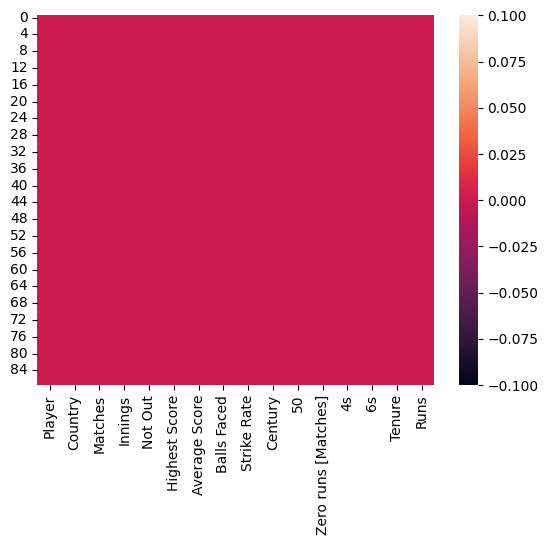

In [9]:
sns.heatmap(df.isnull(), cbar=True,)

In [10]:
df.duplicated().sum()

0

In [11]:
df.describe().T

count          mean          std       min         25%  \
Matches               88.0    365.431818   104.135830    202.00    285.7500   
Innings               88.0    421.329545   107.002495    252.00    337.0000   
Not Out               88.0     46.943182    24.002566     12.00     30.7500   
Highest Score         88.0    241.784091    57.521100    135.00    199.7500   
Average Score         88.0     40.816364     5.230841     23.92     37.6600   
Balls Faced           88.0  23275.147727  8045.725295   9809.00  18233.0000   
Strike Rate           88.0     66.841818    12.652238     45.90     56.9675   
Century               88.0     31.034091    15.438010      6.00     20.0000   
50                    88.0     83.579545    24.978944     46.00     66.7500   
Zero runs [Matches]   88.0     25.284091     8.992908      9.00     19.7500   
4s                    88.0   1593.363636   547.409263    737.00   1242.0000   
6s                    88.0    158.681818   113.449928      9.00     77.7500   
Tenure                88.0     14.909091     3.479452      6.00     12.0000   
Runs                  88.0  15301.284091  4665.091415  10028.00  11728.5000   

                           50%       75%       max  
Matches                360.500    425.25    664.00  
Innings                410.000    467.25    782.00  
Not Out                 41.000     62.25    142.00  
Highest Score          232.500    278.50    400.00  
Average Score           40.545     44.87     53.62  
Balls Faced          21564.000  26505.25  50817.00  
Strike Rate             65.110     74.71    114.14  
Century                 28.500     38.25    100.00  
50                      77.500     93.50    164.00  
Zero runs [Matches]     23.000     33.00     53.00  
4s                    1470.000   1778.25   4076.00  
6s                     132.500    215.25    553.00  
Tenure                  15.000     17.00     24.00  
Runs                 13986.000  17274.50  34357.00

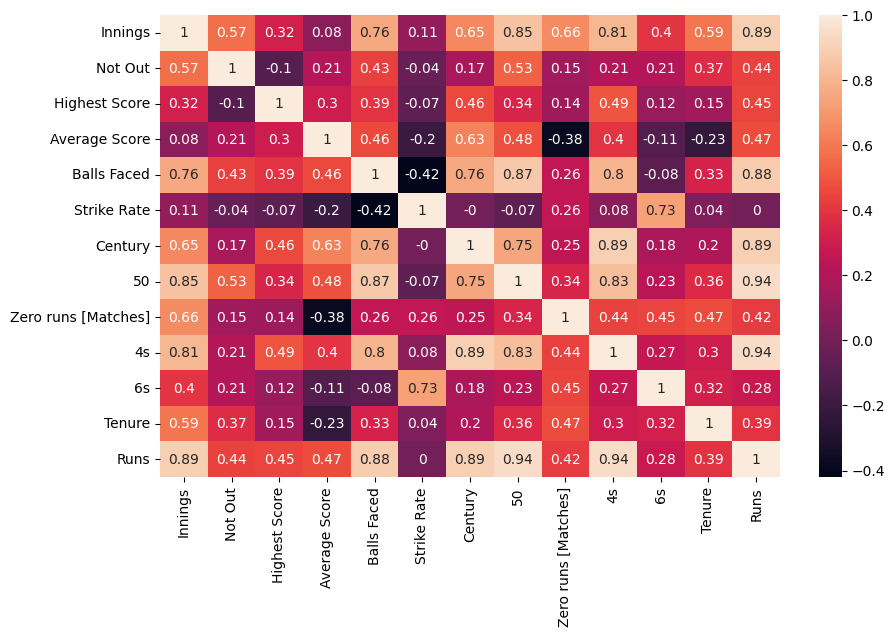

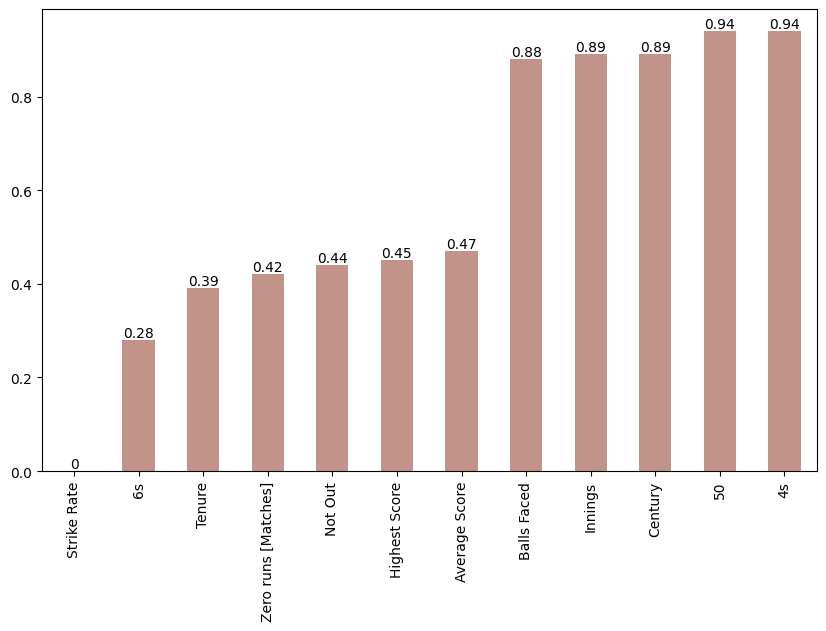

In [12]:
corr = df.iloc[:, 3:].corr().round(2)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, color=palette[0])

plt.figure(figsize=(10, 6))
ax = corr["Runs"].sort_values().drop("Runs").plot(kind="bar", color=palette[0])
for container in ax.containers:
    ax.bar_label(container)

# <h1 style= 'background: #C29389; border:2; color:white; padding-top:10px'><center><b>Features wrt Players [Top Ten]</b></center></h1>

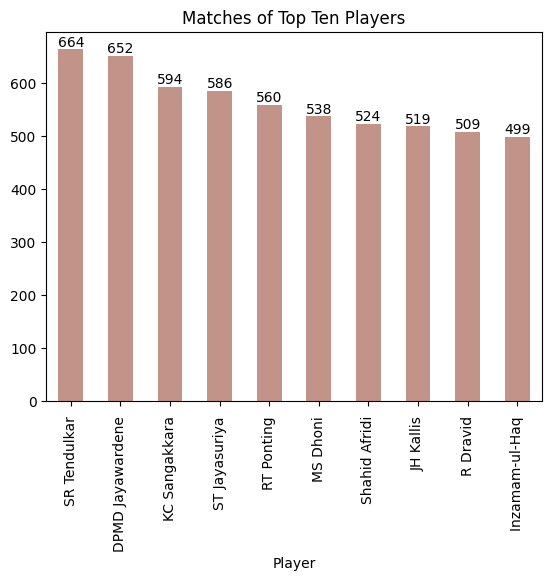

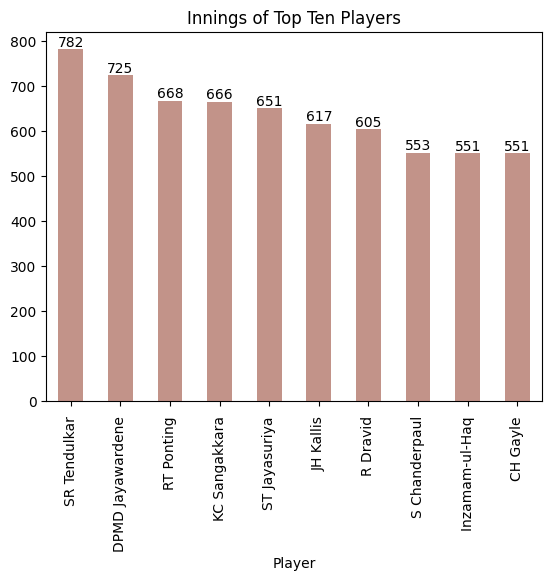

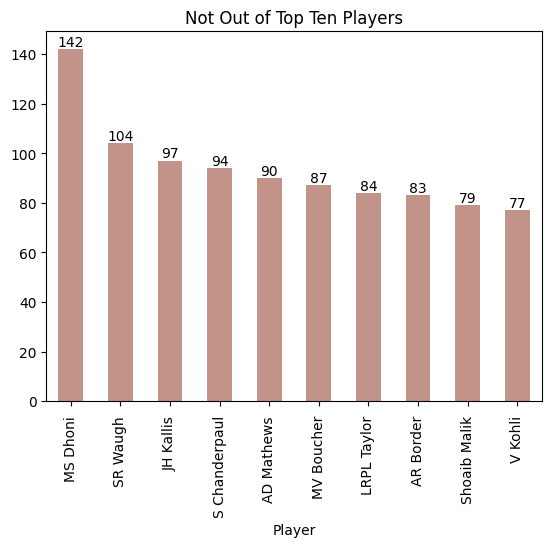

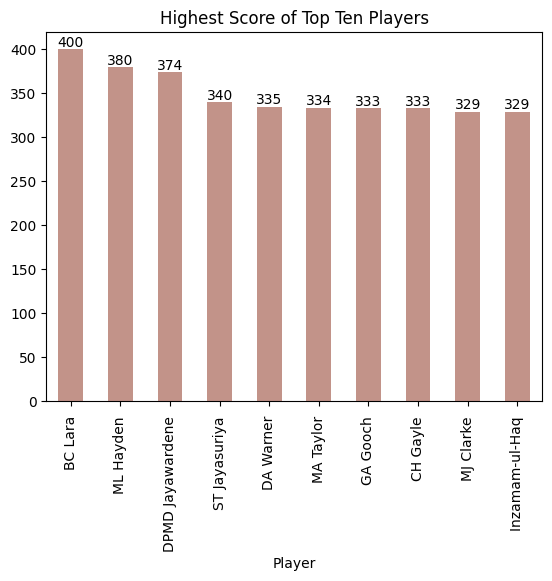

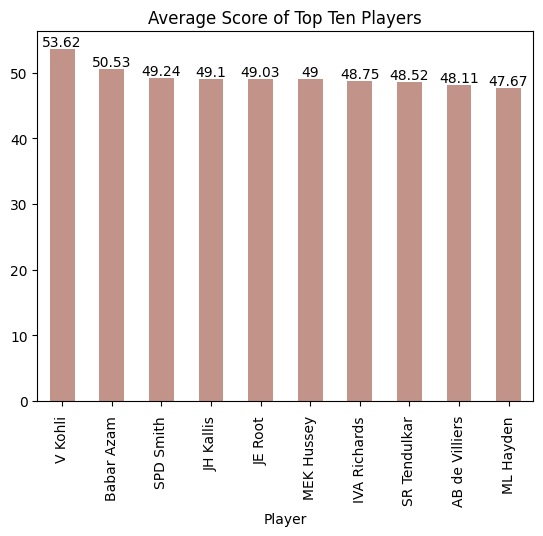

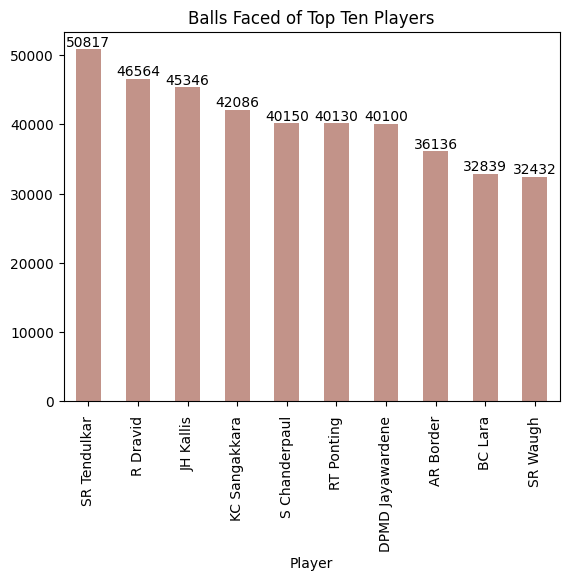

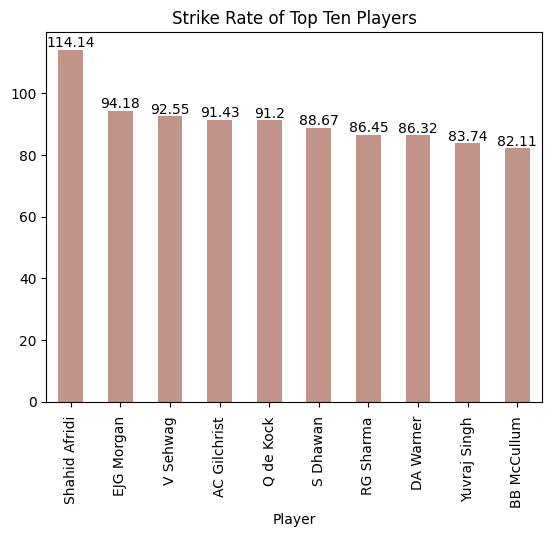

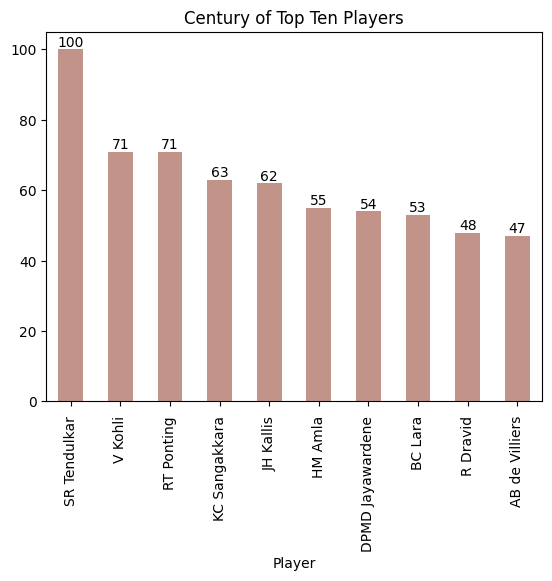

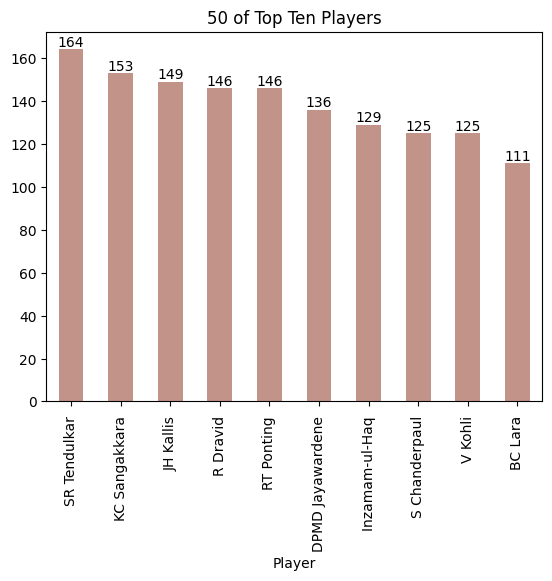

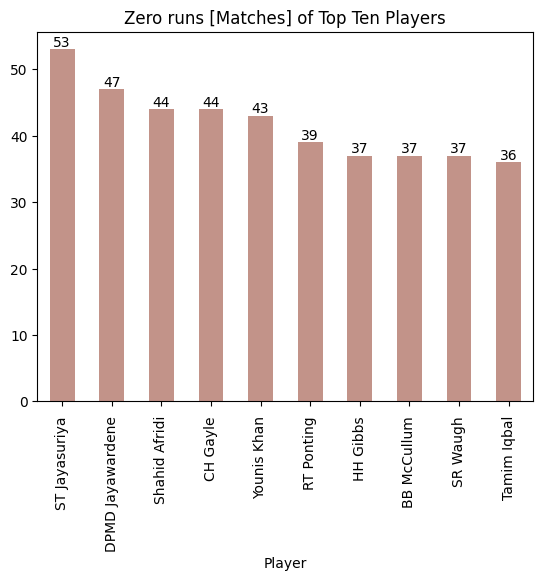

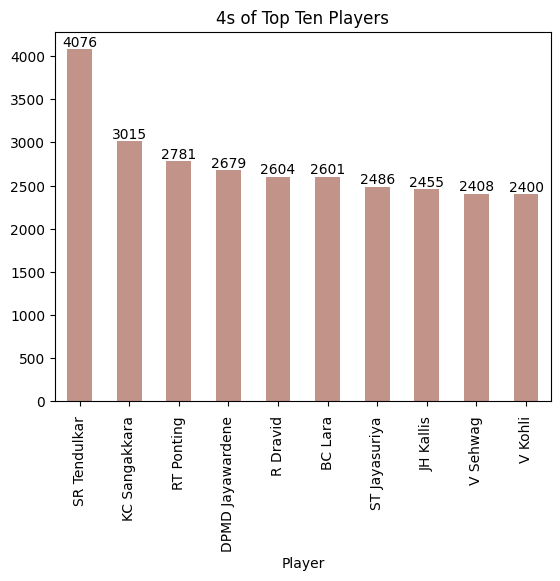

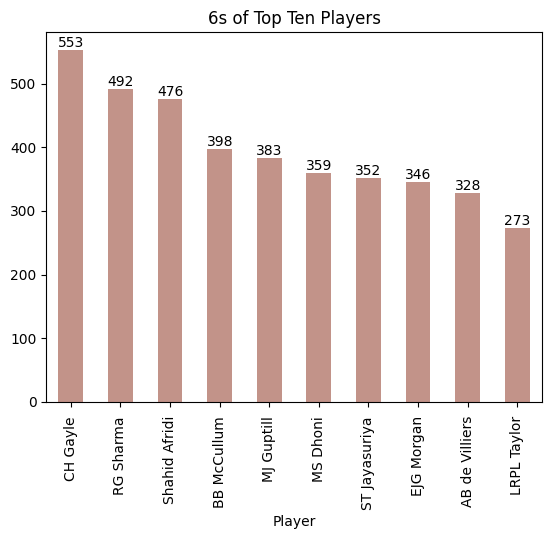

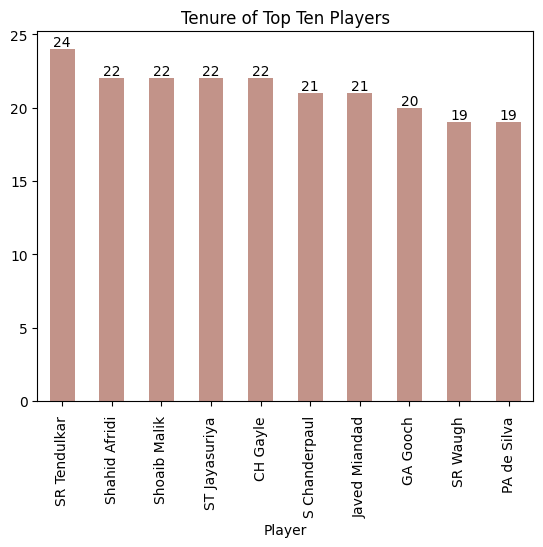

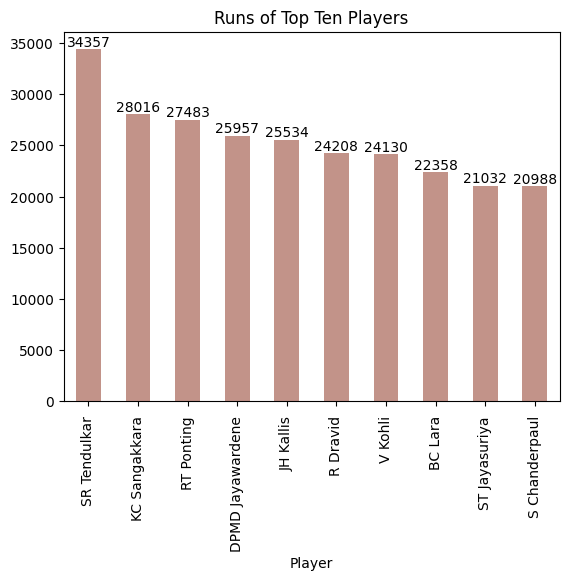

In [13]:
for col in df.iloc[:,2:]:
    
    ax = df.groupby("Player")[col].sum().sort_values(ascending=False).head(10).plot(kind="bar", color=palette[0])
    plt.title(f"{col} of Top Ten Players")
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

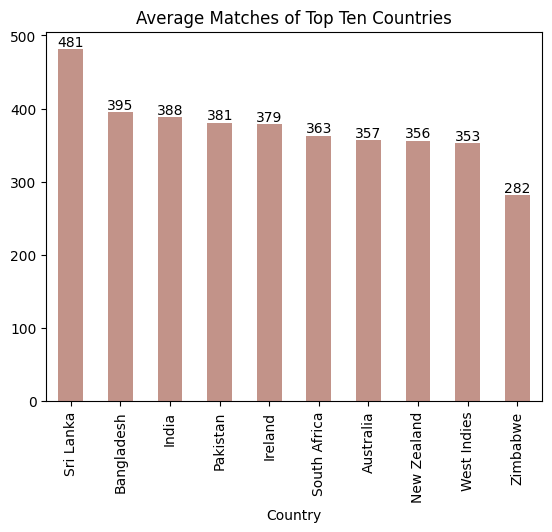

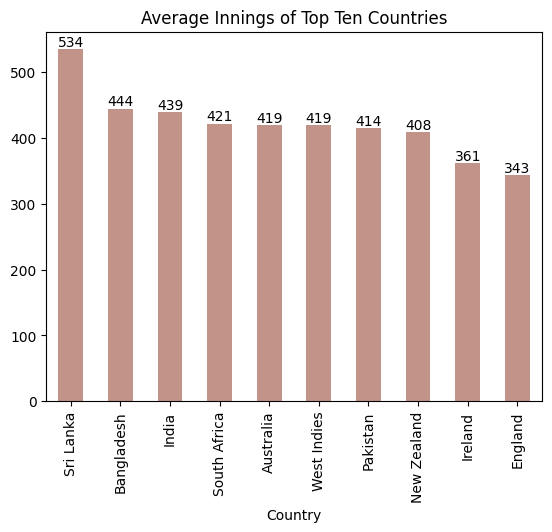

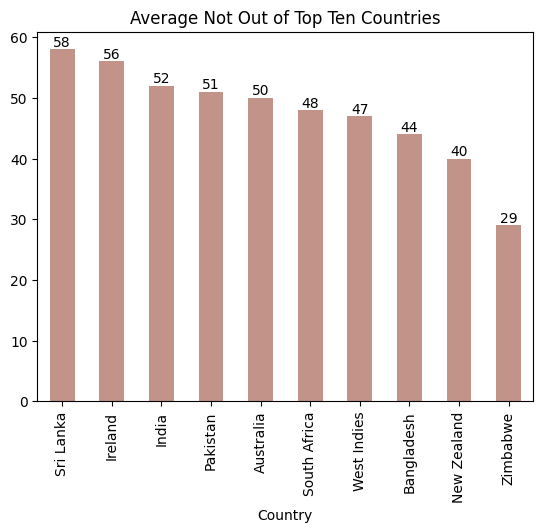

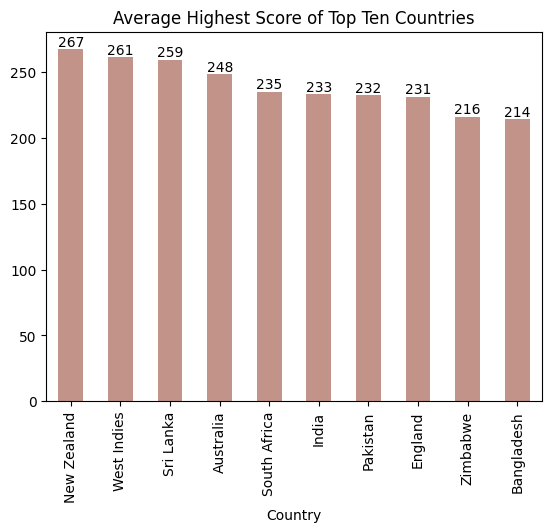

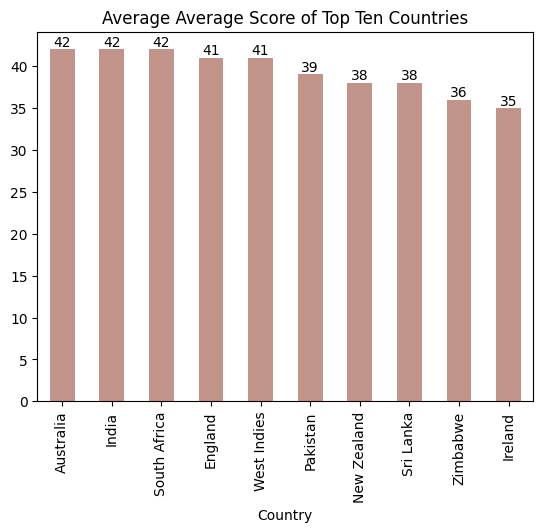

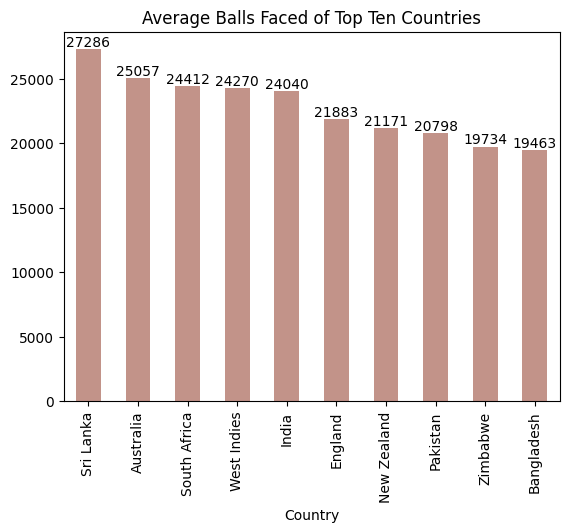

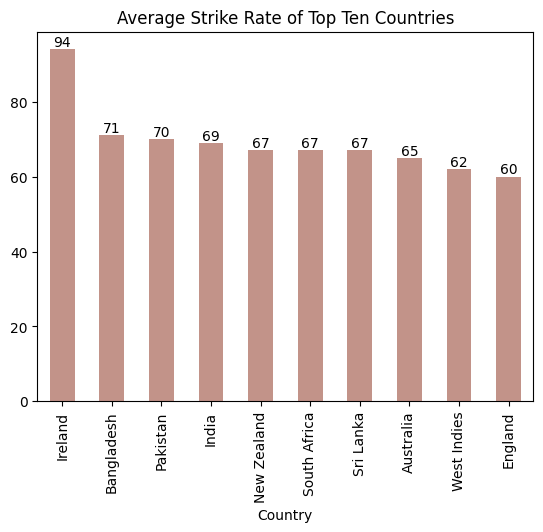

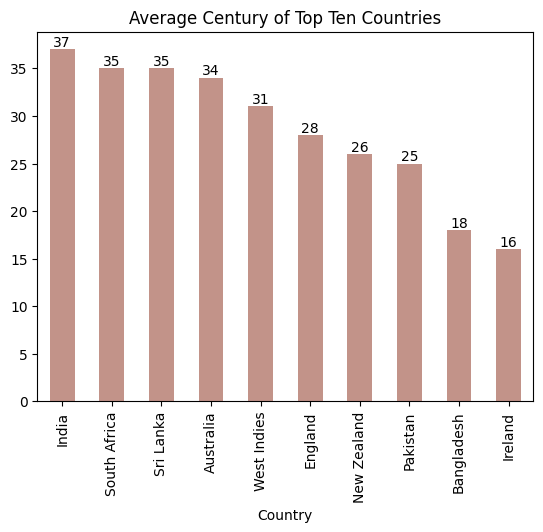

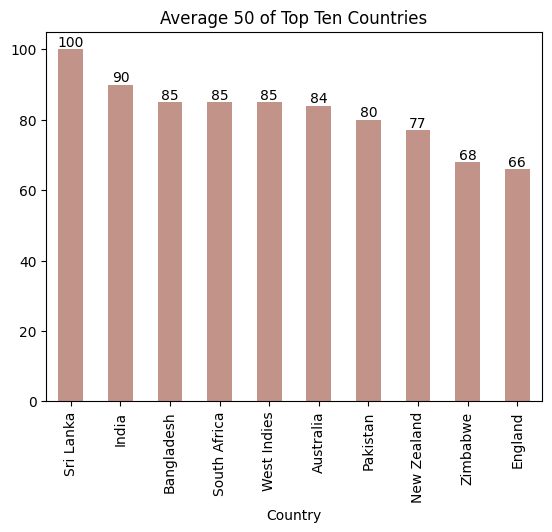

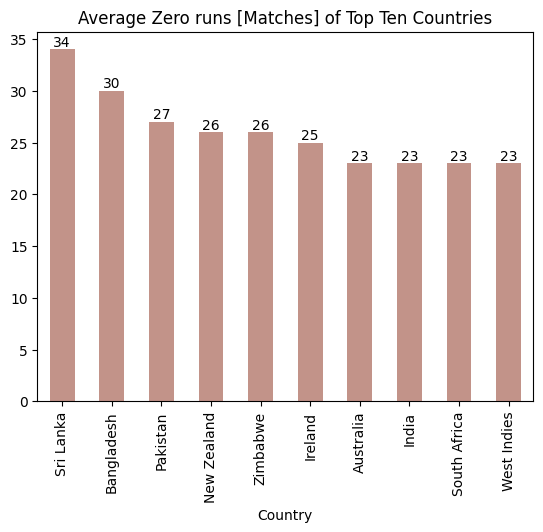

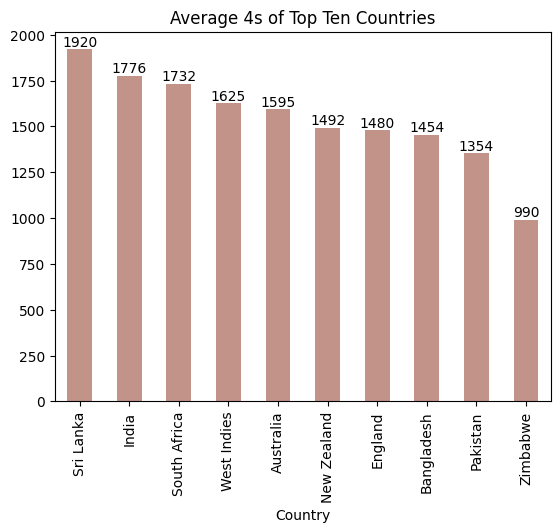

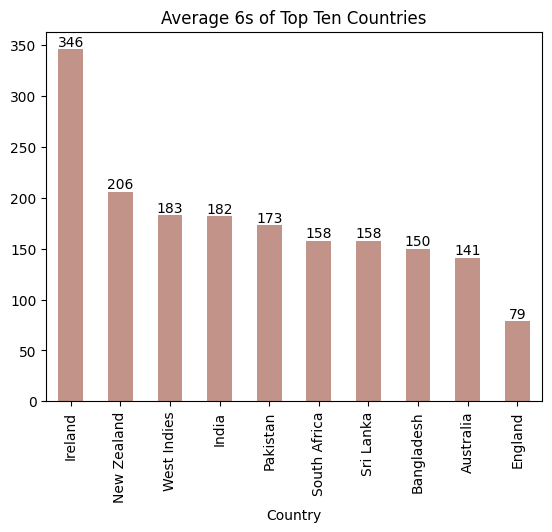

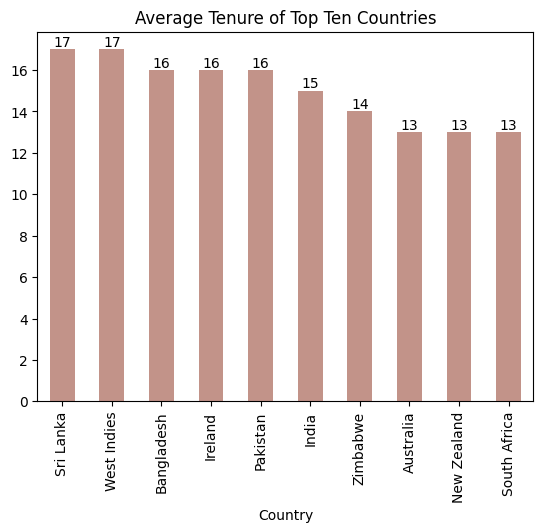

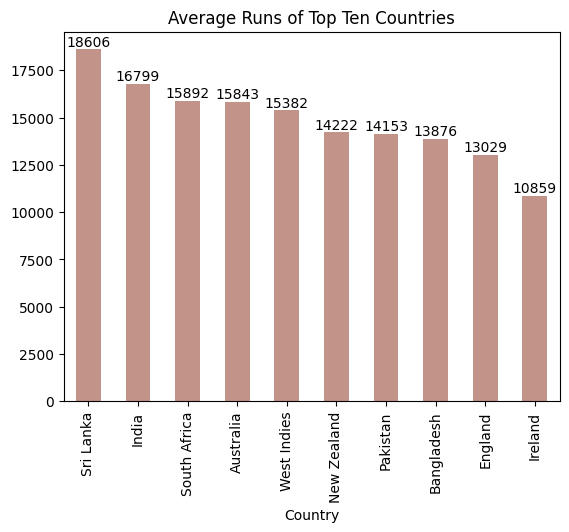

In [14]:
for col in df.iloc[:,2:]:
    
    ax = df.groupby("Country")[col].mean().astype(int).sort_values(ascending=False).head(10).plot(kind="bar",color=palette[0])
    plt.title(f"Average {col} of Top Ten Countries")
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

In [15]:
india = df[df["Country"] == "India"]
pak = df[df["Country"] == "Pakistan"]
sri = df[df["Country"] == "Sri Lanka"]
aus = df[df["Country"] == "Australia"]
sa = df[df["Country"] == "South Africa"]
wi = df[df["Country"] == "West Indies"]
nz = df[df["Country"] == "New Zealand"]
eng = df[df["Country"] == "England"]
ban = df[df["Country"] == "Bangladesh"]
zb = df[df["Country"] == "Zimbabwe"]
ire = df[df["Country"] == "Ireland"]

# **Average Score of Players**

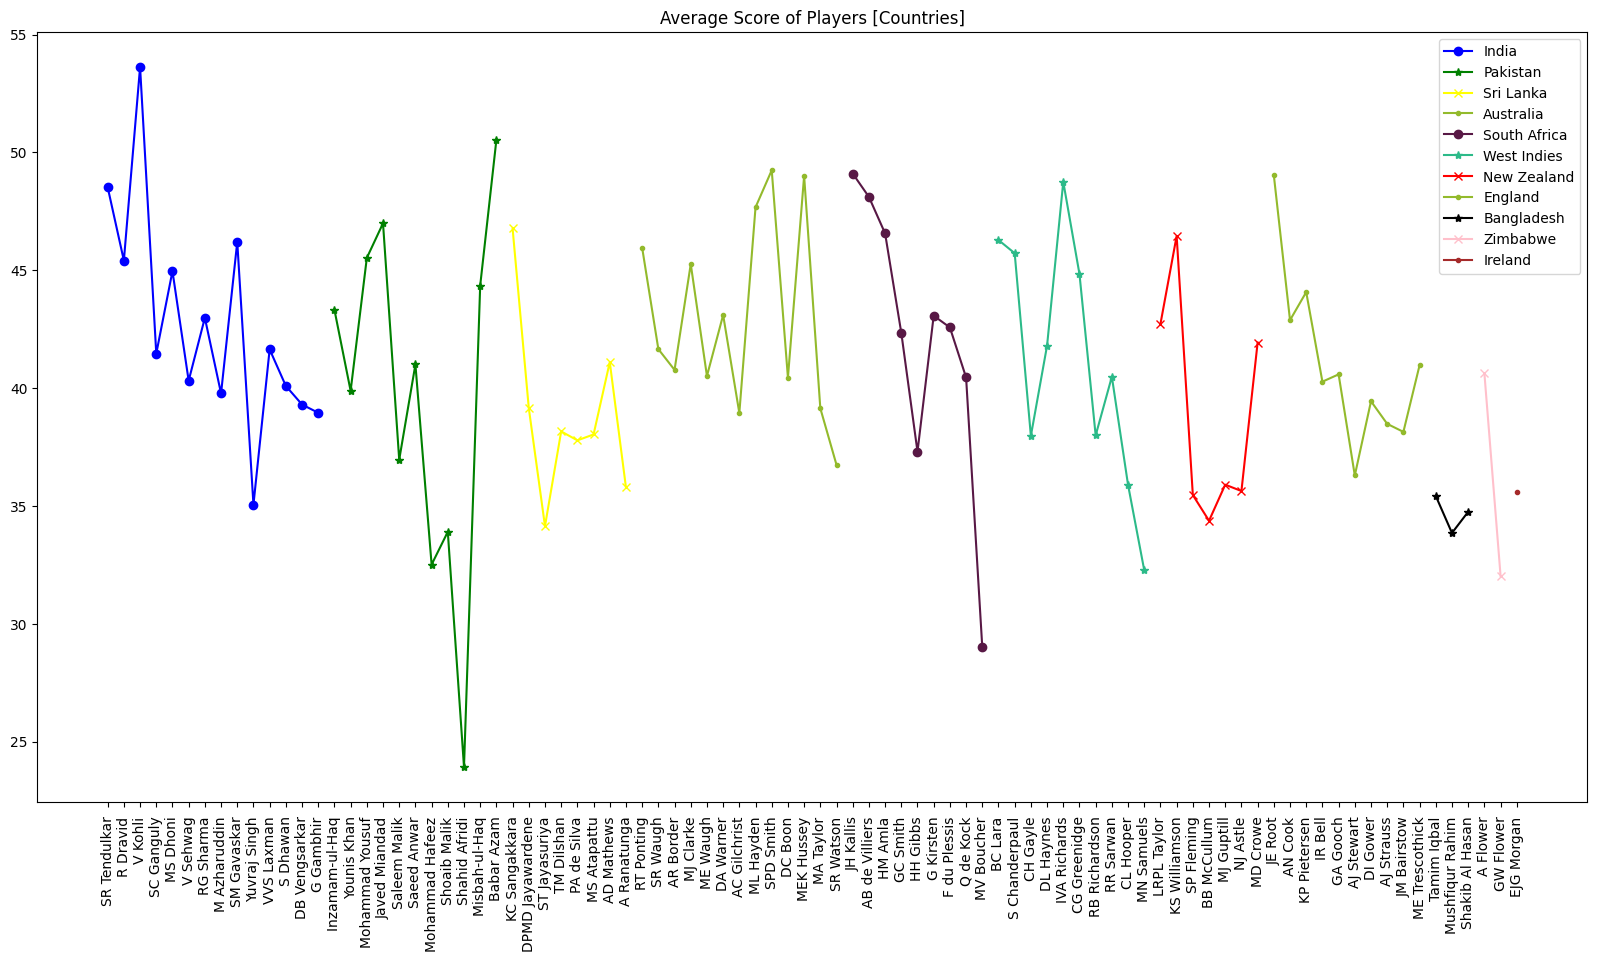

In [16]:
plt.figure(figsize=(20,10))

plt.plot(india["Player"], india["Average Score"], marker="o", color="blue", label="India")
plt.plot(pak["Player"], pak["Average Score"], marker="*", color="green", label="Pakistan")
plt.plot(sri["Player"], sri["Average Score"], marker="x", color="yellow", label="Sri Lanka")
plt.plot(aus["Player"], aus["Average Score"], marker=".", color="#93BA2C", label="Australia")
plt.plot(sa["Player"], sa["Average Score"], marker="o", color="#581845", label="South Africa")
plt.plot(wi["Player"], wi["Average Score"], marker="*", color="#2CBA89", label="West Indies")
plt.plot(nz["Player"], nz["Average Score"], marker="x", color="red", label="New Zealand")
plt.plot(eng["Player"], eng["Average Score"], marker=".", color="#93BA2C", label="England")
plt.plot(ban["Player"], ban["Average Score"], marker="*", color="black", label="Bangladesh")
plt.plot(zb["Player"], zb["Average Score"], marker="x", color="pink", label="Zimbabwe")
plt.plot(ire["Player"], ire["Average Score"], marker=".", color="brown", label="Ireland")
plt.xticks(rotation=90)
plt.legend()
plt.title("Average Score of Players [Countries]")
plt.show()


# **Highest Score of Players**

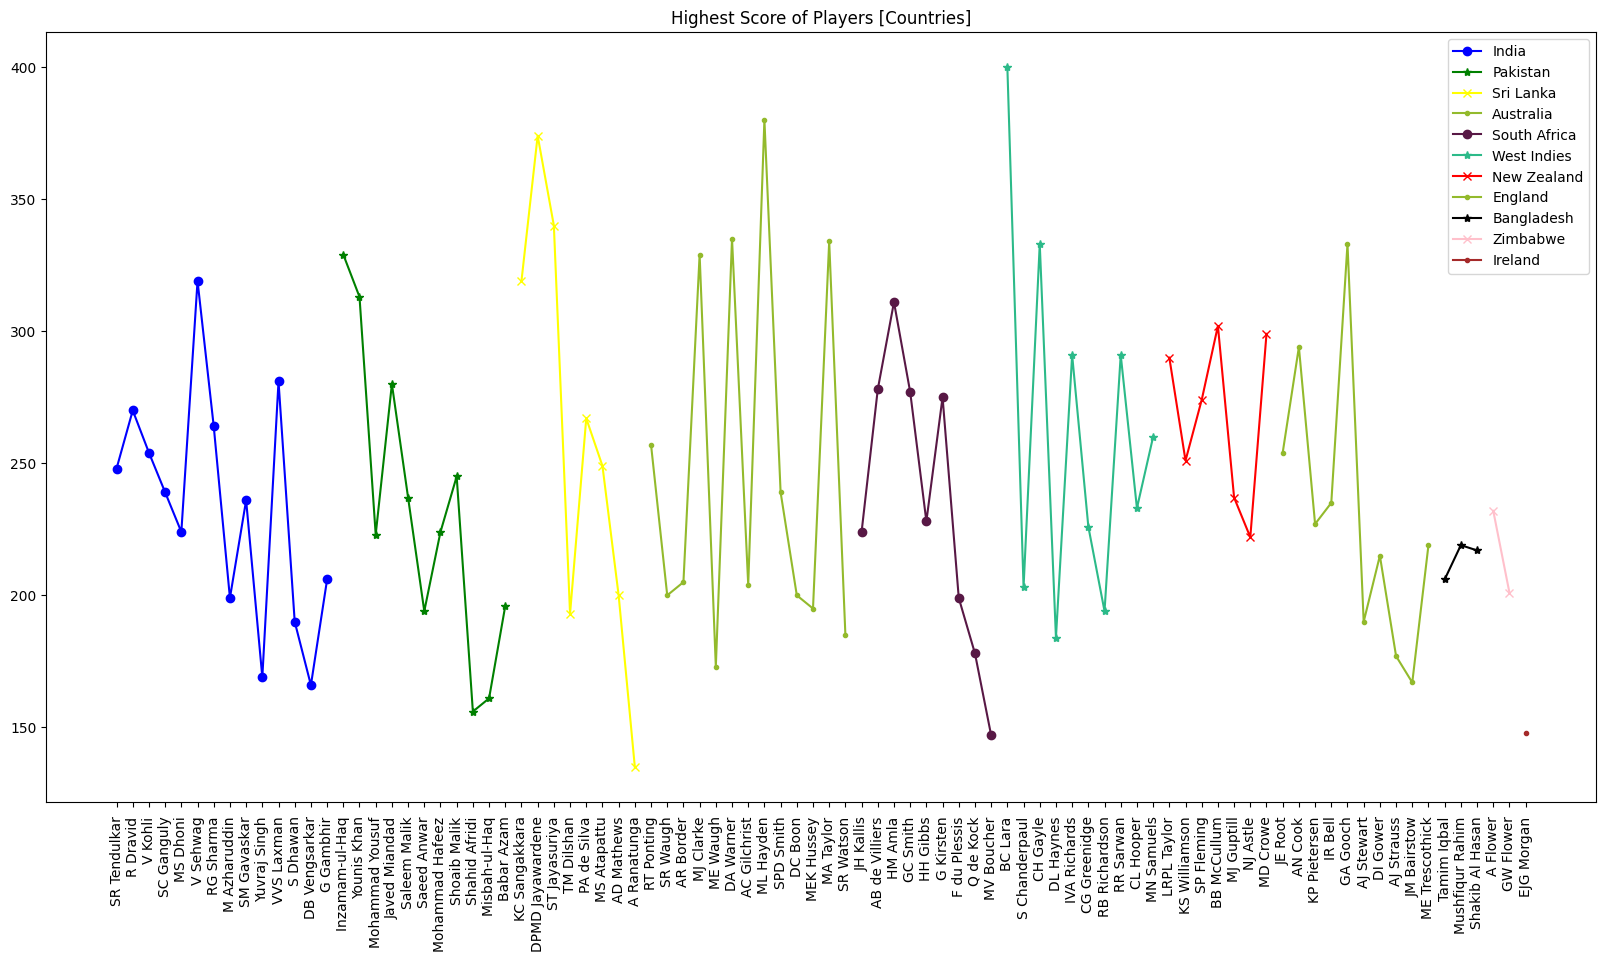

In [17]:
plt.figure(figsize=(20,10))

plt.plot(india["Player"], india["Highest Score"], marker="o", color="blue", label="India")
plt.plot(pak["Player"], pak["Highest Score"], marker="*", color="green", label="Pakistan")
plt.plot(sri["Player"], sri["Highest Score"], marker="x", color="yellow", label="Sri Lanka")
plt.plot(aus["Player"], aus["Highest Score"], marker=".", color="#93BA2C", label="Australia")
plt.plot(sa["Player"], sa["Highest Score"], marker="o", color="#581845", label="South Africa")
plt.plot(wi["Player"], wi["Highest Score"], marker="*", color="#2CBA89", label="West Indies")
plt.plot(nz["Player"], nz["Highest Score"], marker="x", color="red", label="New Zealand")
plt.plot(eng["Player"], eng["Highest Score"], marker=".", color="#93BA2C", label="England")
plt.plot(ban["Player"], ban["Highest Score"], marker="*", color="black", label="Bangladesh")
plt.plot(zb["Player"], zb["Highest Score"], marker="x", color="pink", label="Zimbabwe")
plt.plot(ire["Player"], ire["Highest Score"], marker=".", color="brown", label="Ireland")
plt.xticks(rotation=90)
plt.legend()
plt.title("Highest Score of Players [Countries]")
plt.show()

# **India**

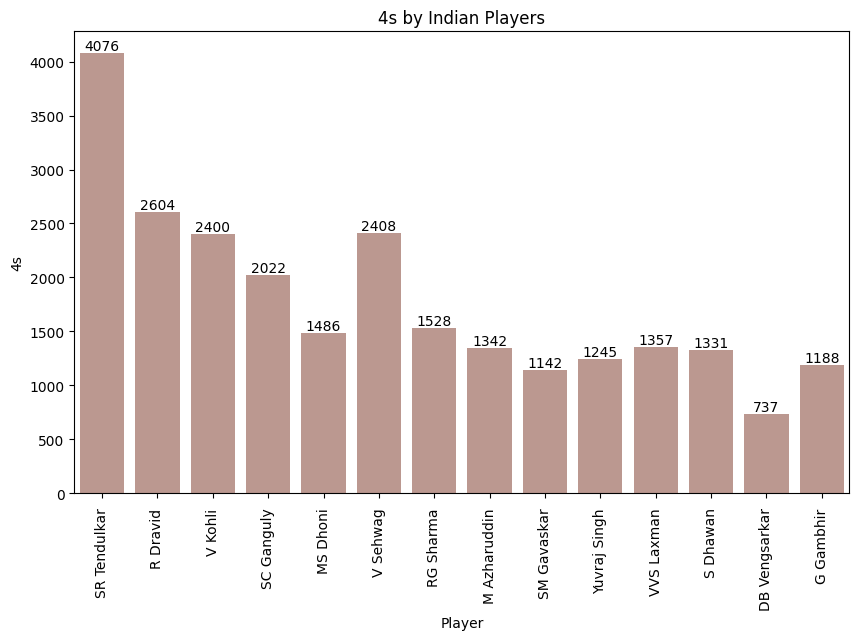

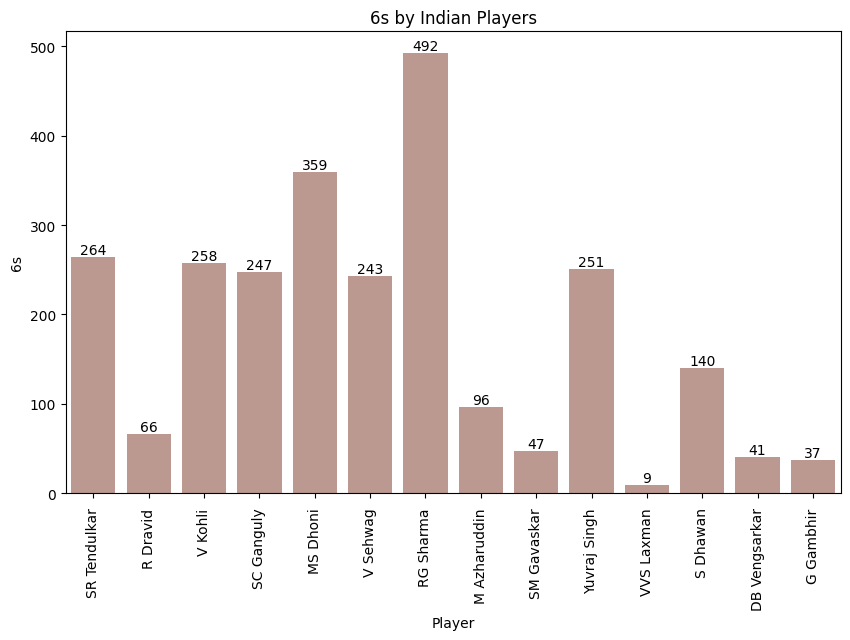

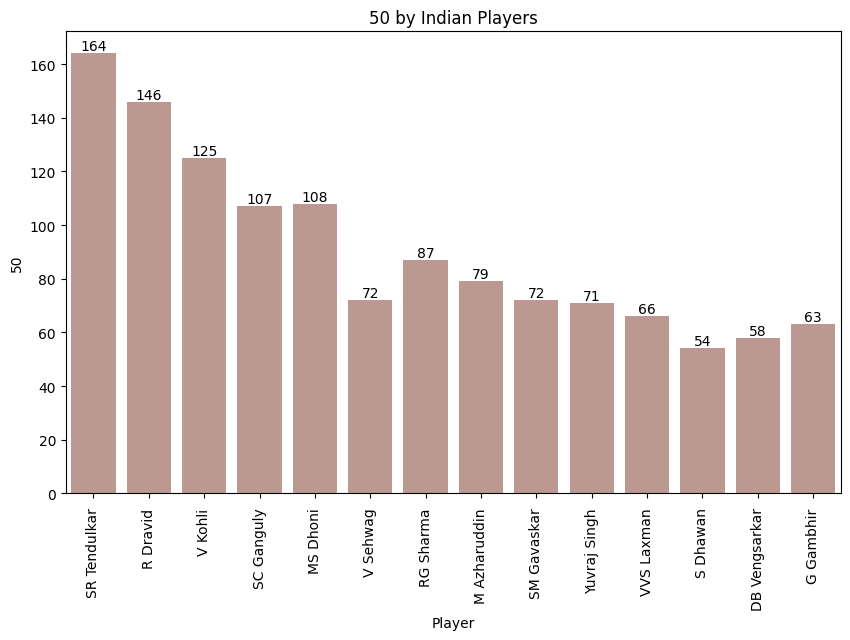

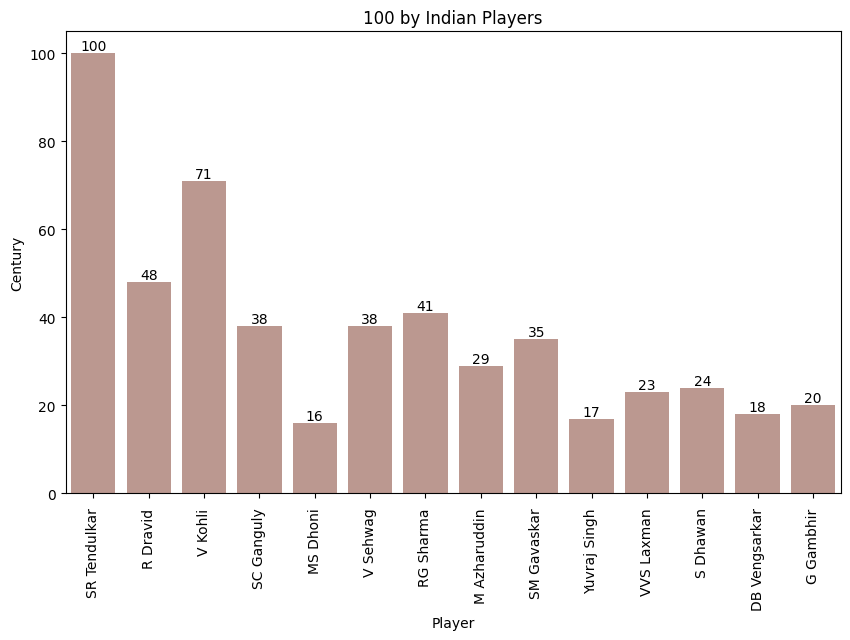

In [18]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=india["Player"], y=india["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by Indian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=india["Player"], y=india["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by Indian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=india["Player"], y=india["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by Indian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=india["Player"], y=india["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by Indian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **Pakistan**

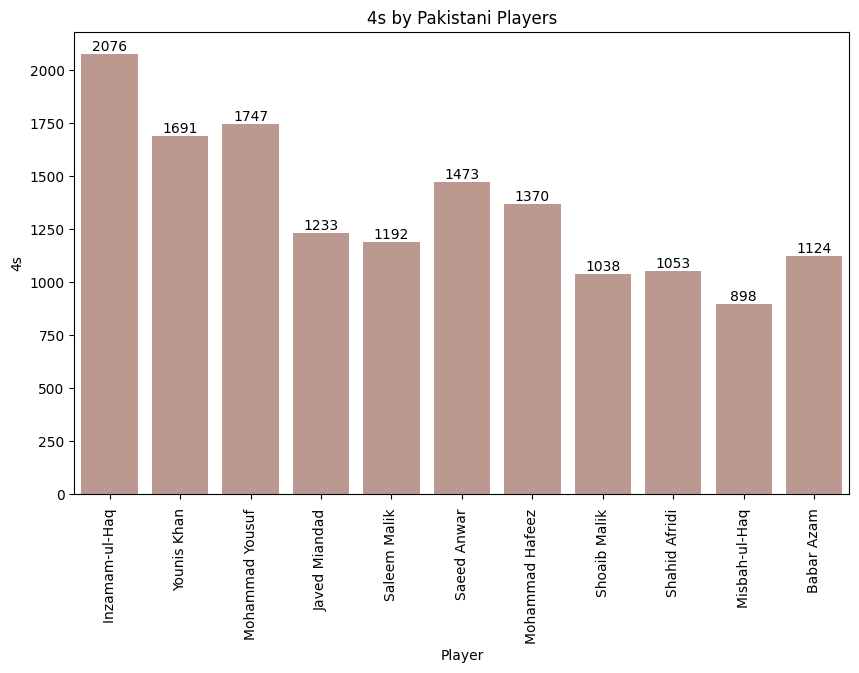

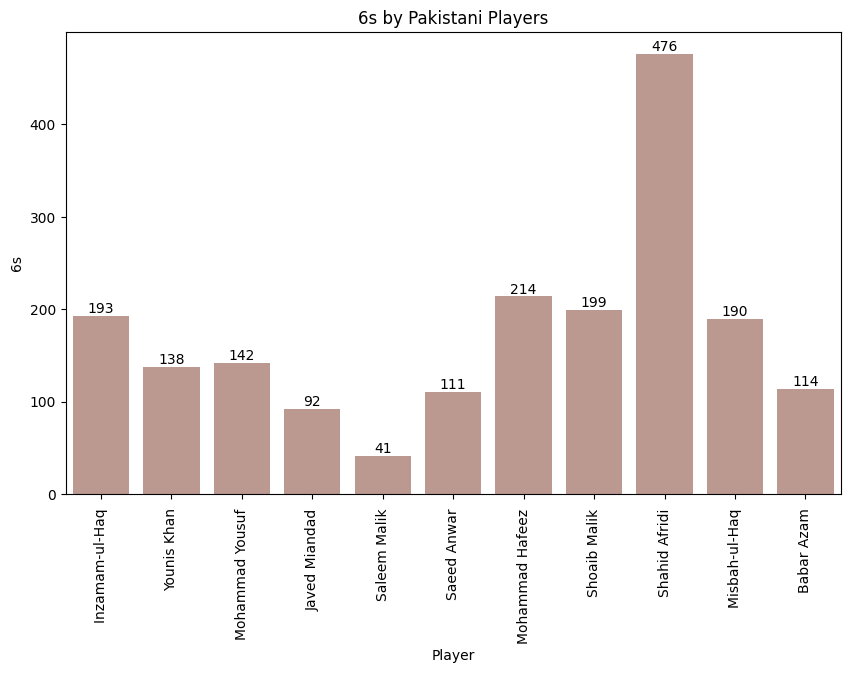

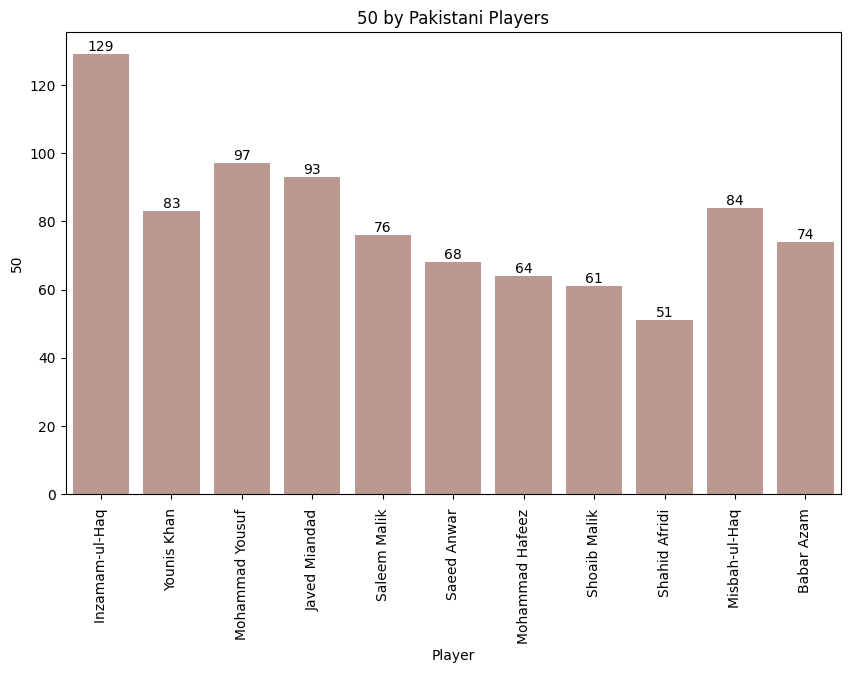

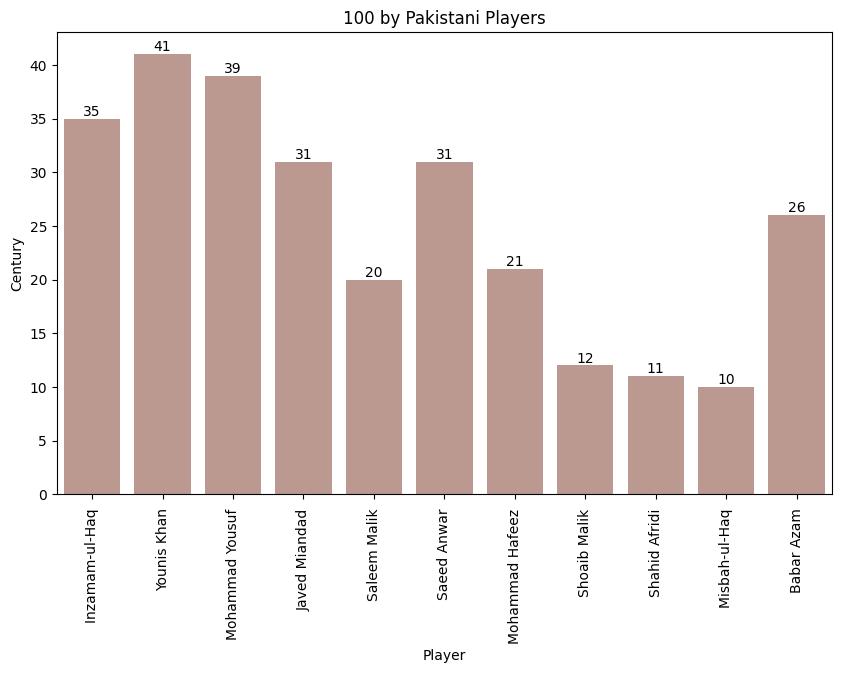

In [19]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=pak["Player"], y=pak["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by Pakistani Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=pak["Player"], y=pak["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by Pakistani Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=pak["Player"], y=pak["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by Pakistani Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=pak["Player"], y=pak["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by Pakistani Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **Sri Lanka**

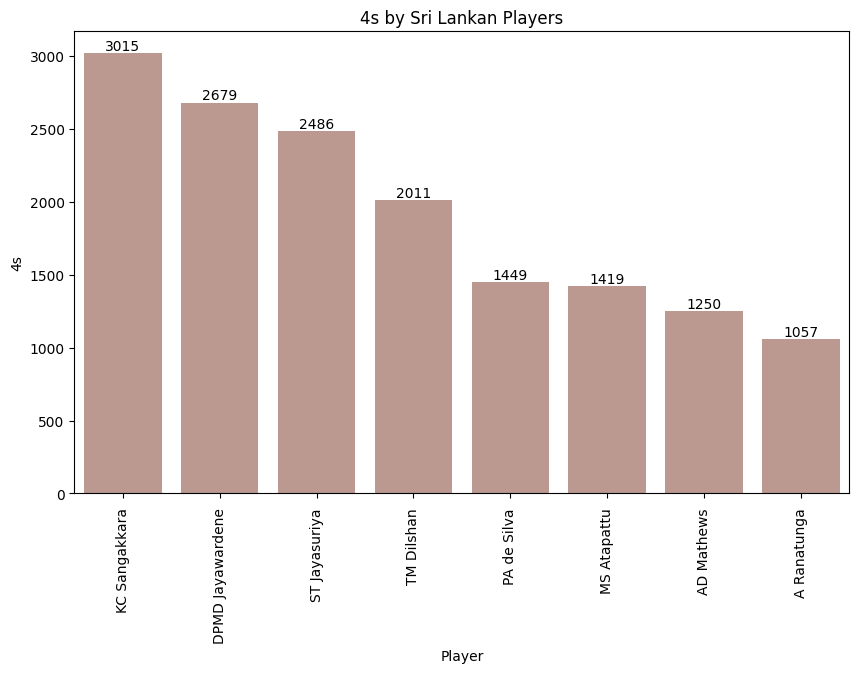

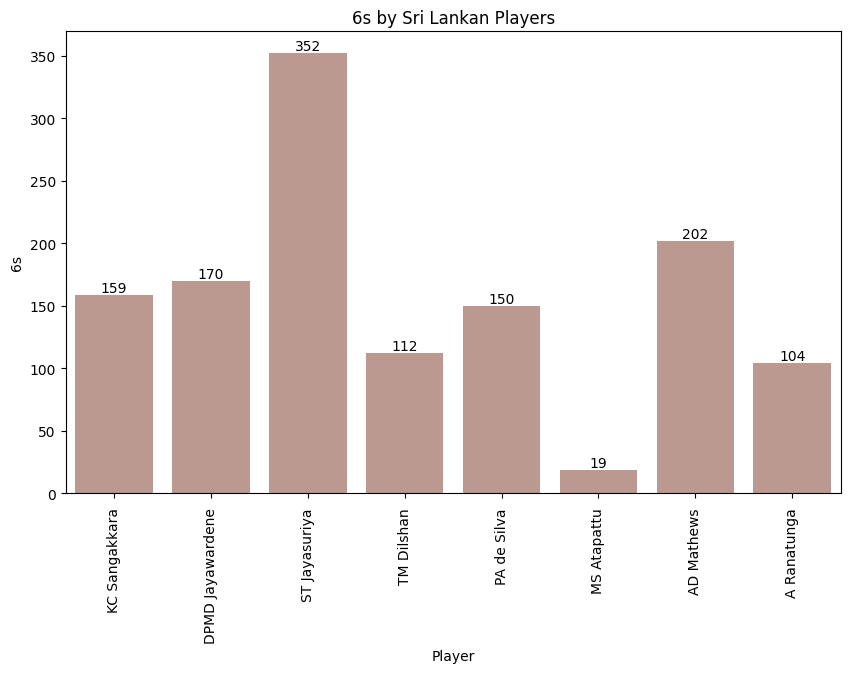

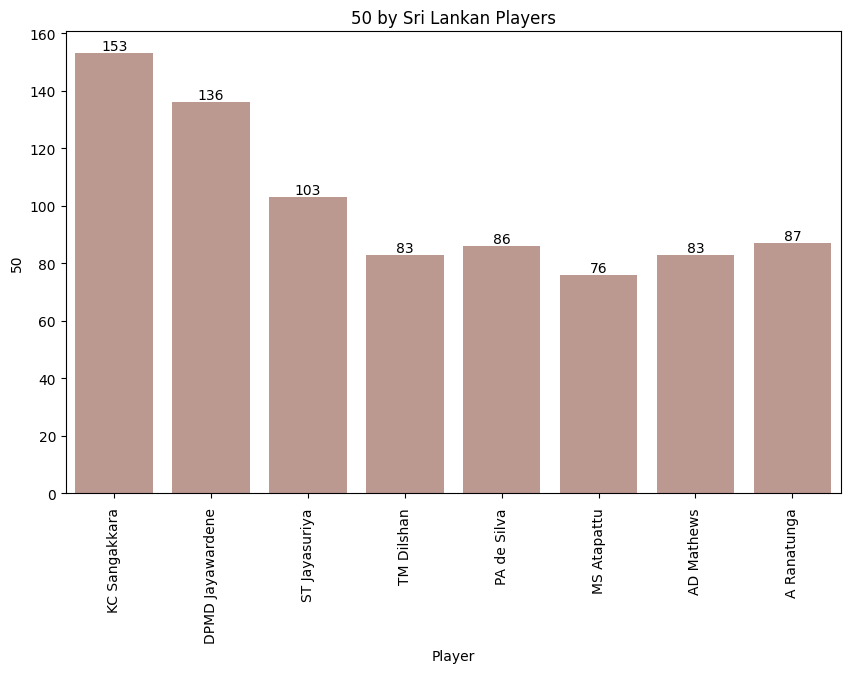

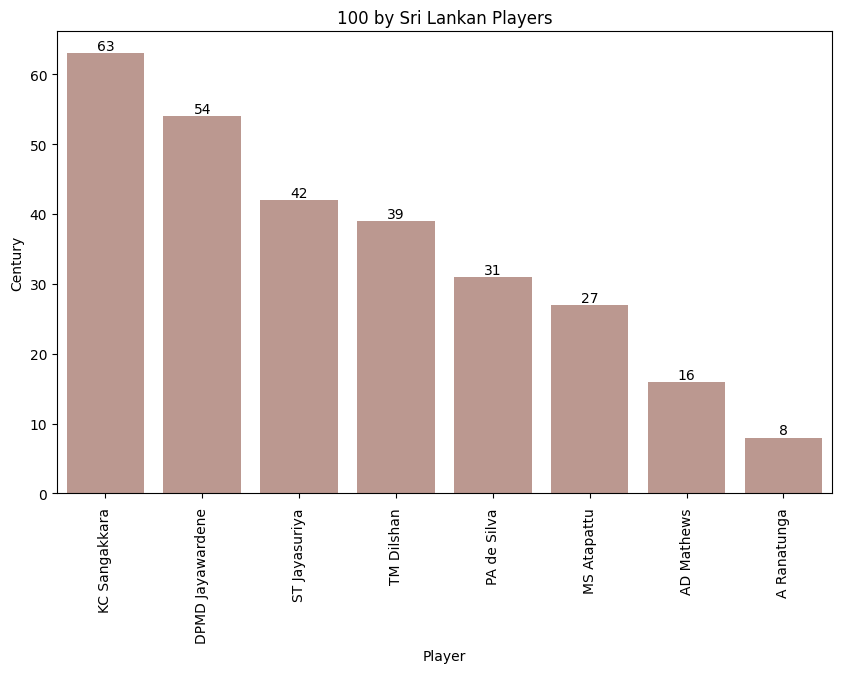

In [20]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=sri["Player"], y=sri["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by Sri Lankan Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=sri["Player"], y=sri["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by Sri Lankan Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=sri["Player"], y=sri["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by Sri Lankan Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=sri["Player"], y=sri["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by Sri Lankan Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **Australia**

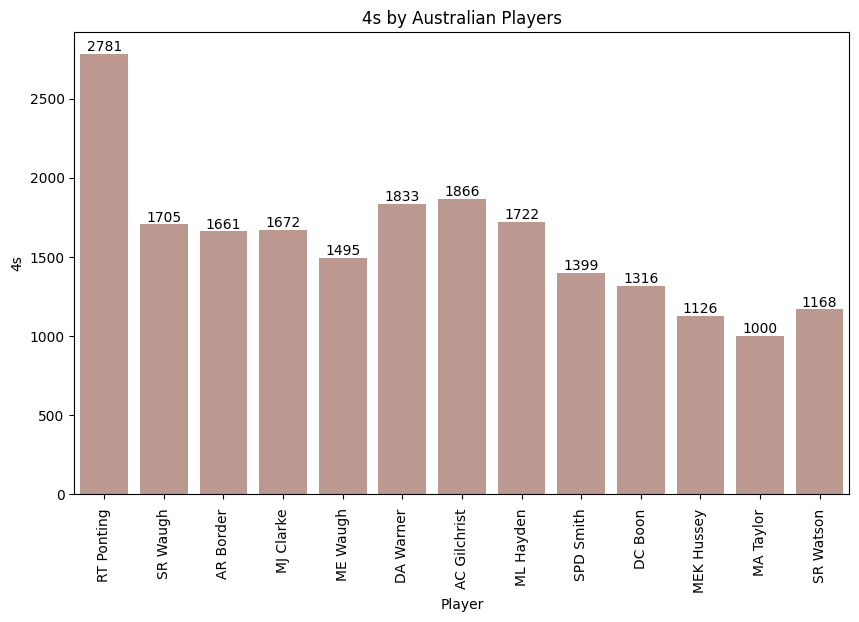

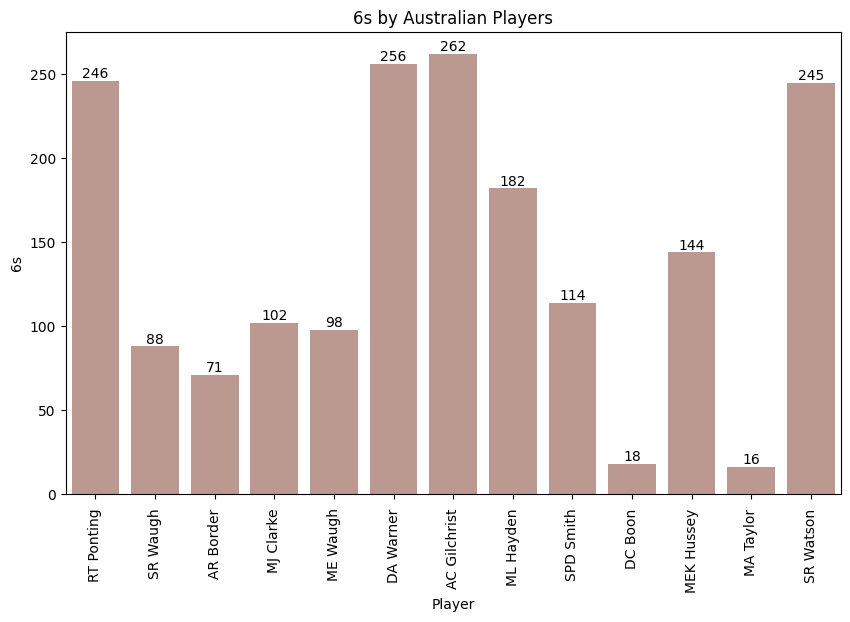

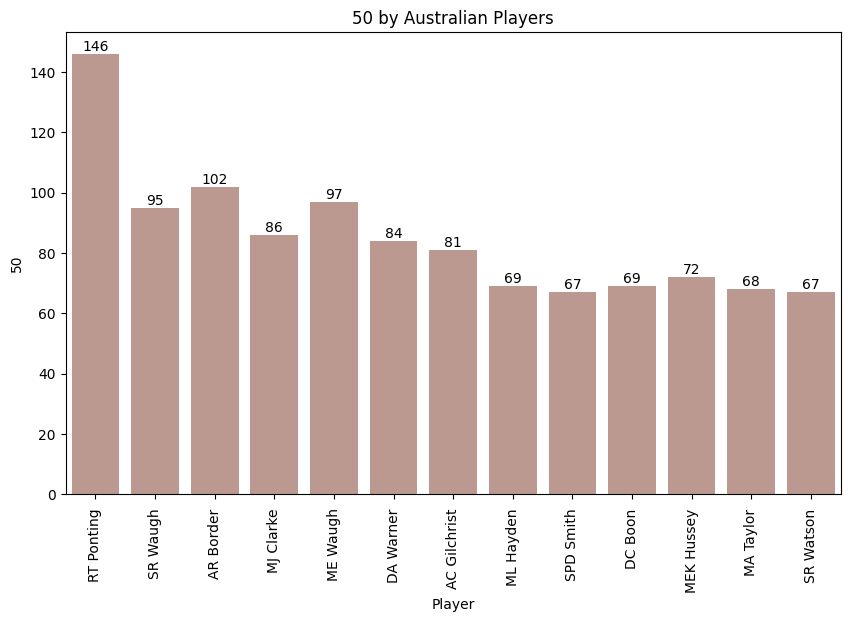

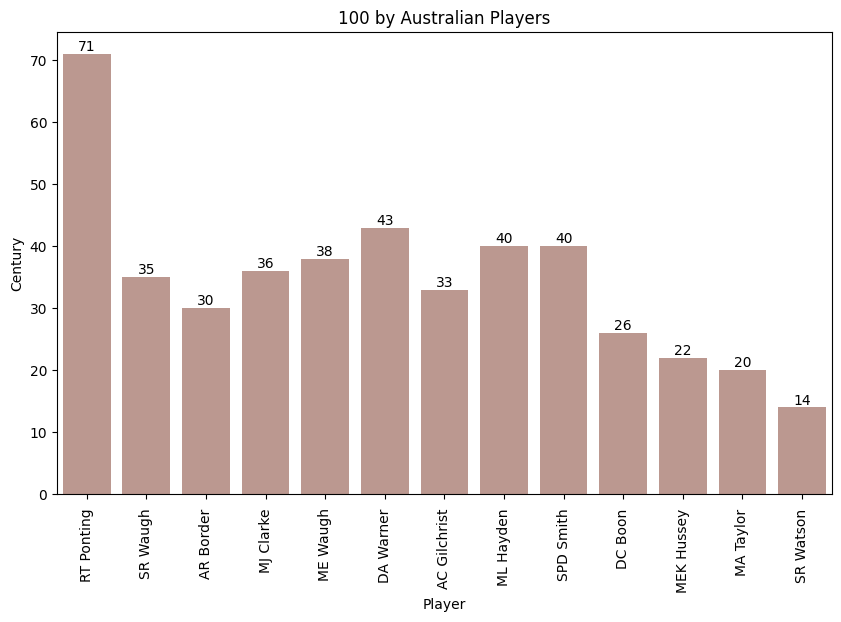

In [21]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=aus["Player"], y=aus["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by Australian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=aus["Player"], y=aus["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by Australian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=aus["Player"], y=aus["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by Australian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=aus["Player"], y=aus["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by Australian Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **South Africa**

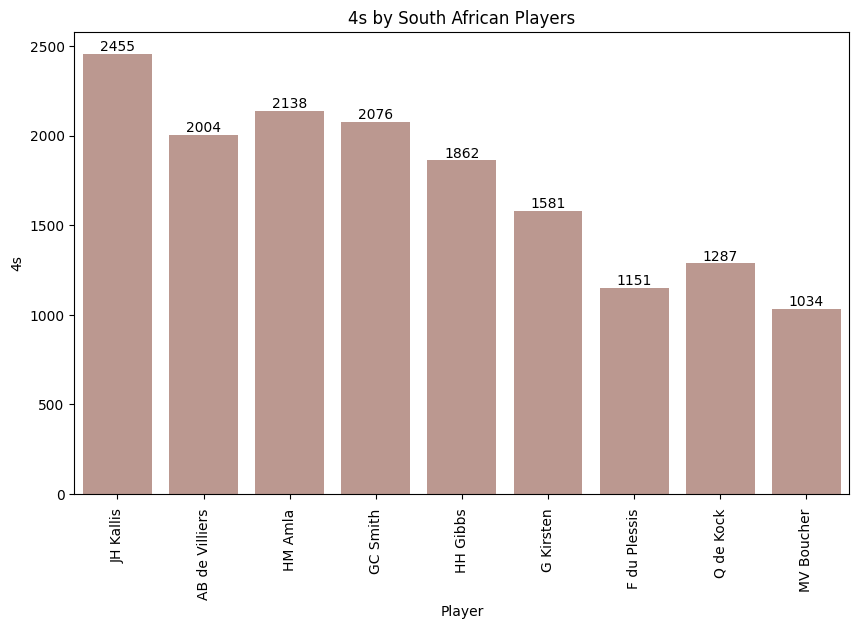

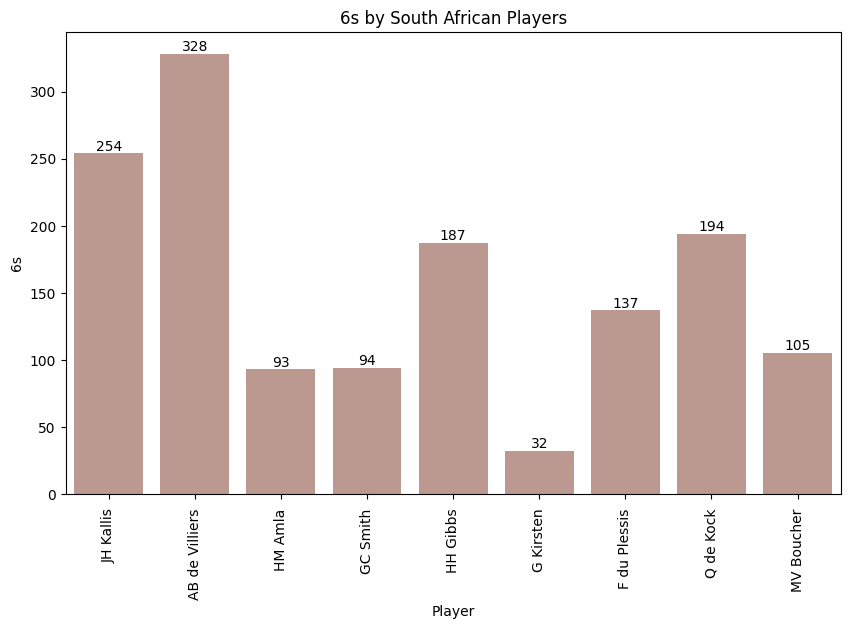

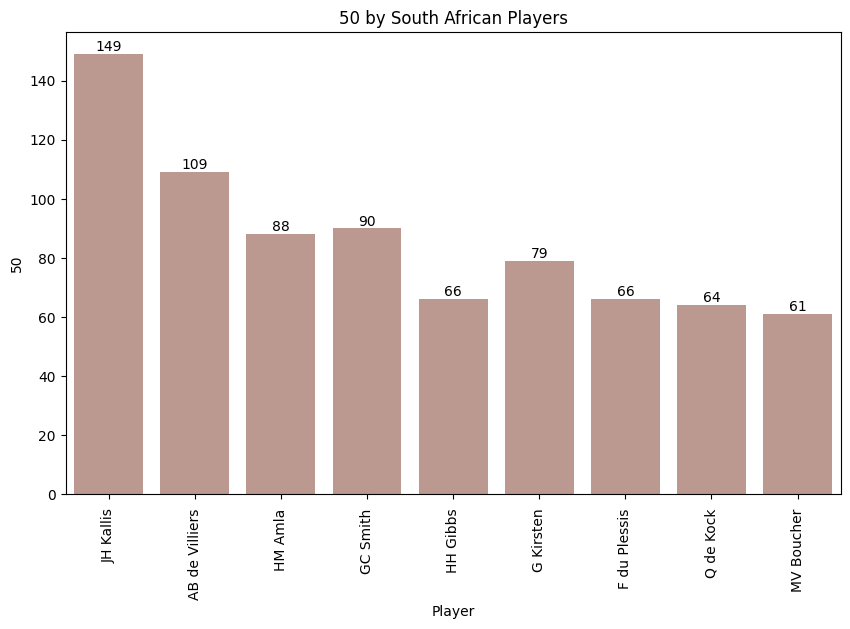

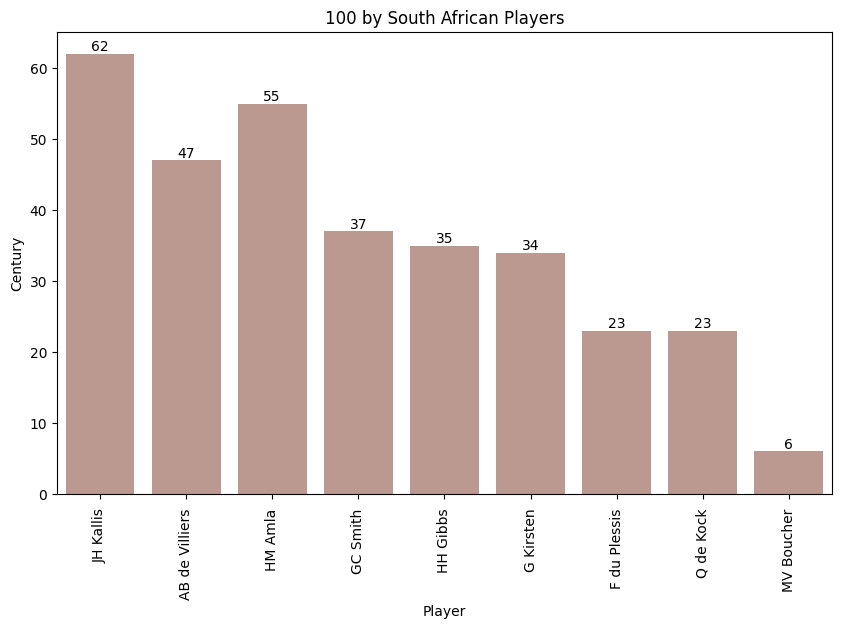

In [22]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=sa["Player"], y=sa["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by South African Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=sa["Player"], y=sa["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by South African Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=sa["Player"], y=sa["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by South African Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=sa["Player"], y=sa["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by South African Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **New Zealand**

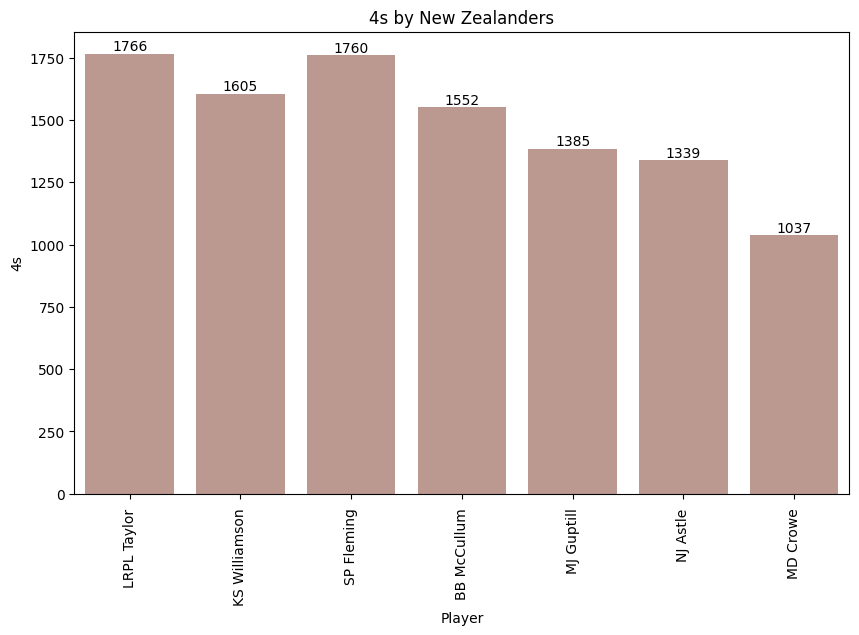

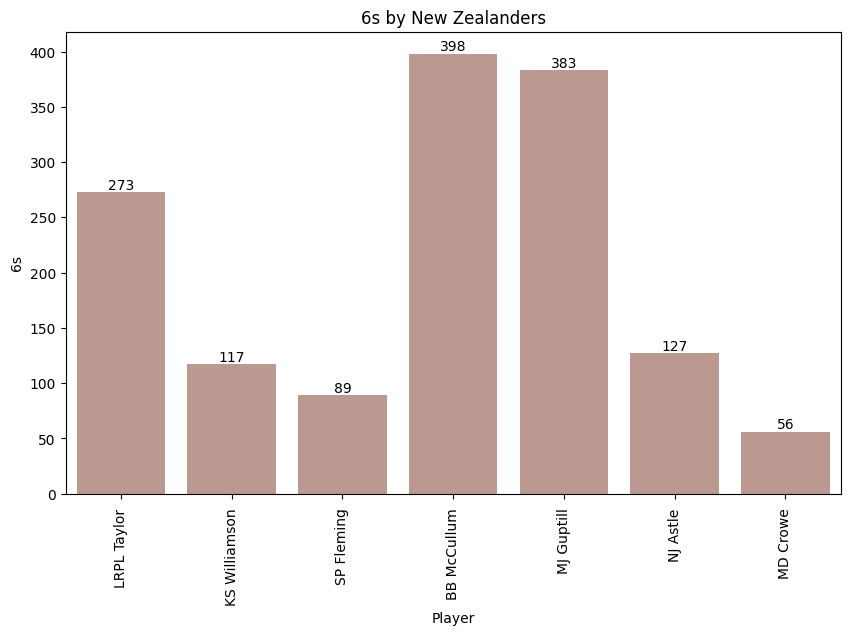

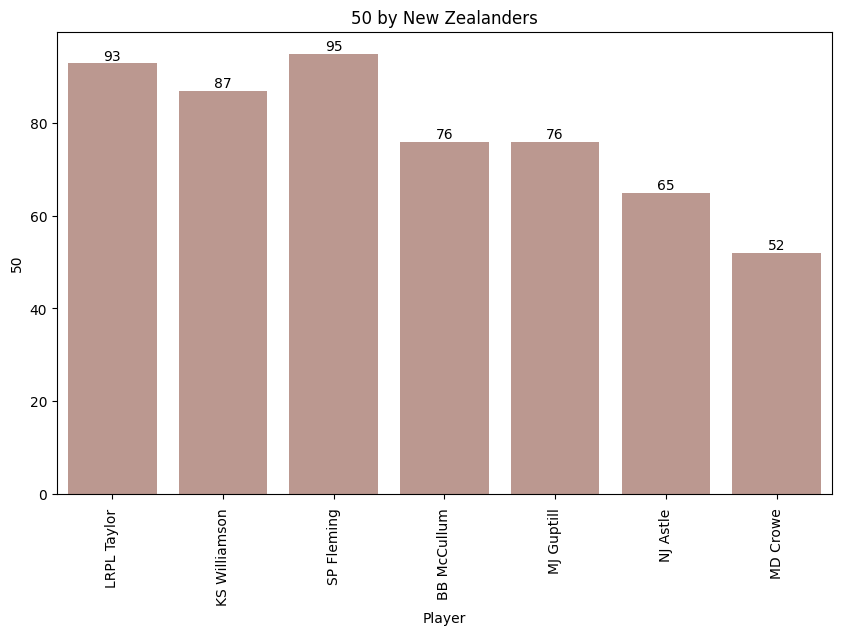

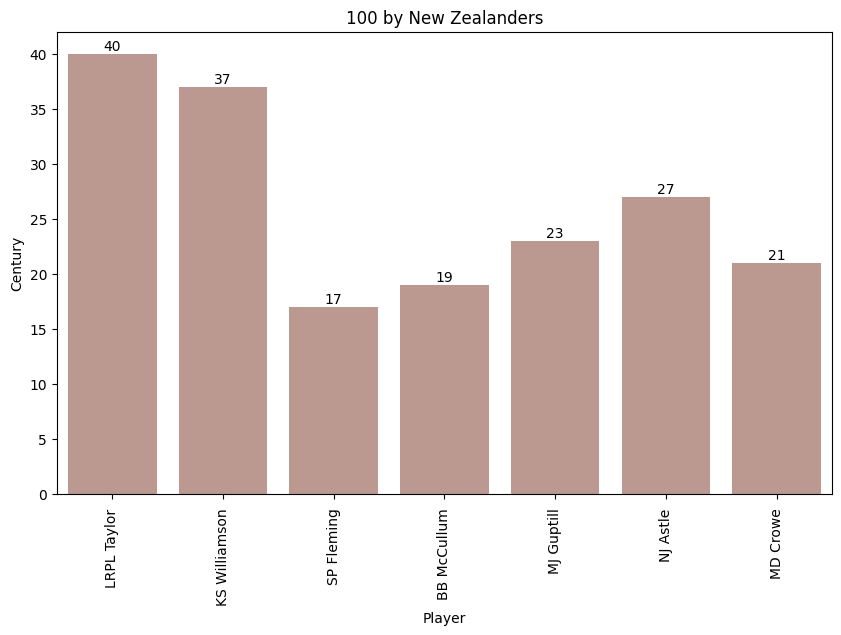

In [23]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=nz["Player"], y=nz["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by New Zealanders")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=nz["Player"], y=nz["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by New Zealanders")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=nz["Player"], y=nz["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by New Zealanders")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=nz["Player"], y=nz["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by New Zealanders")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **West Indies**

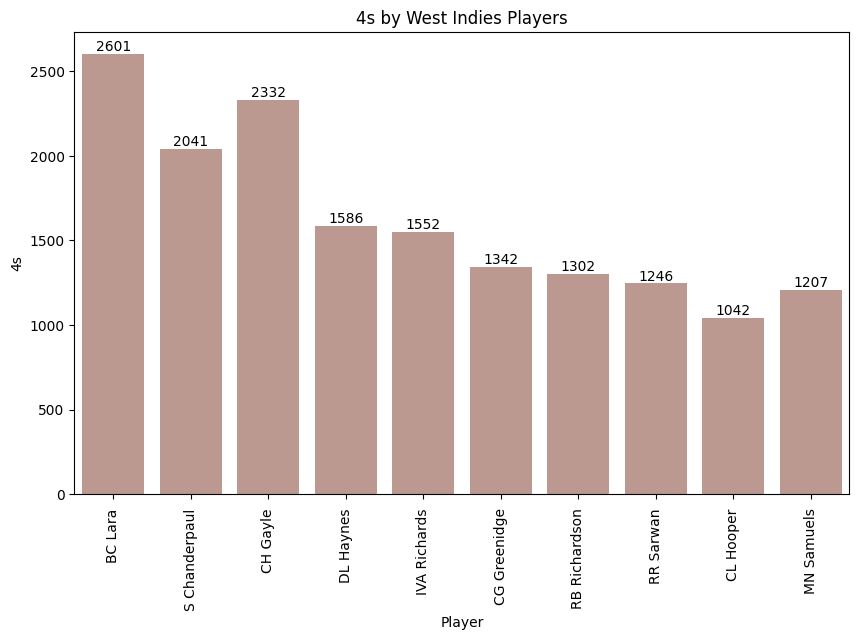

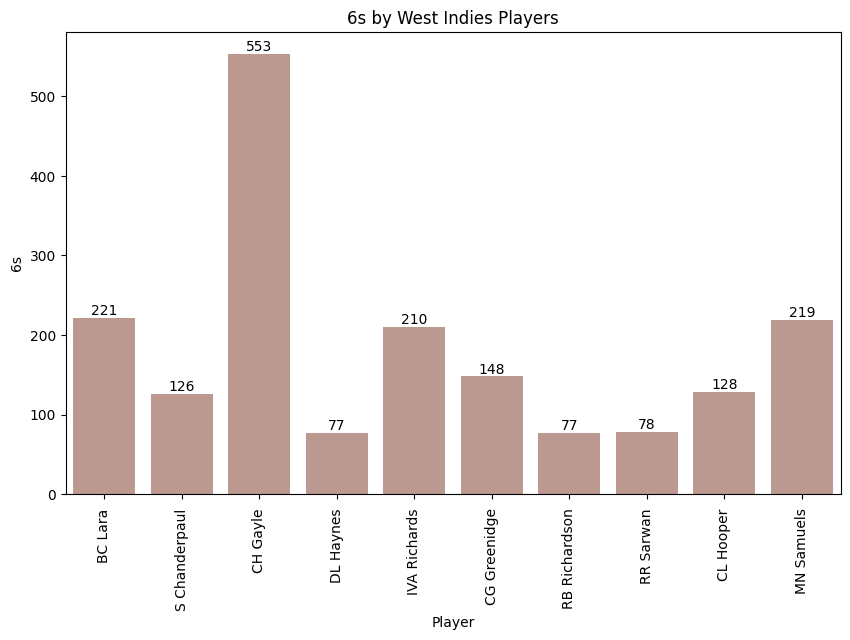

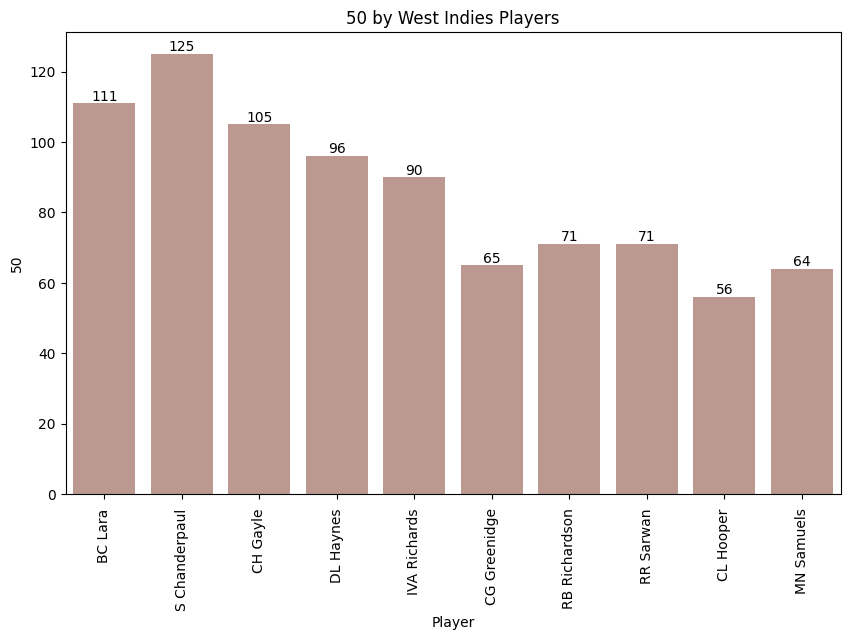

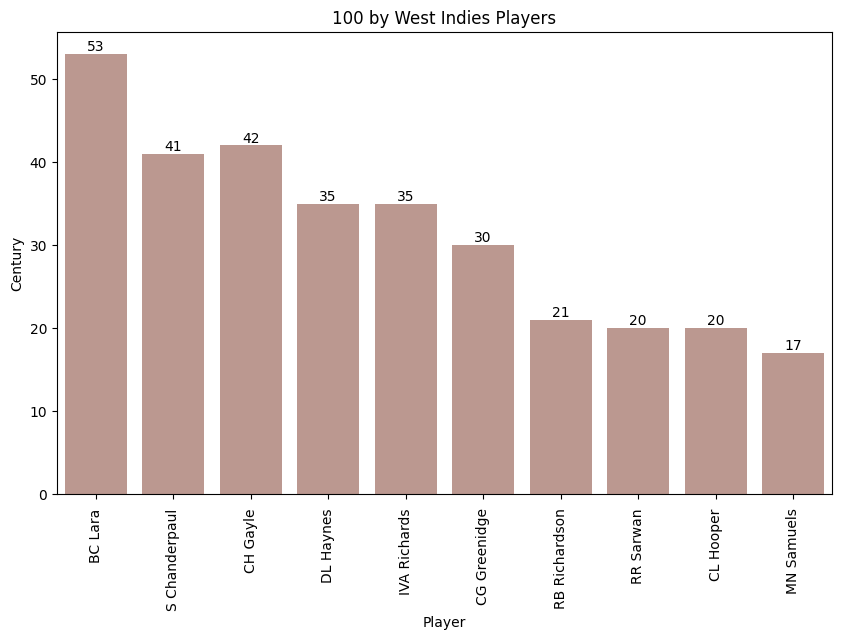

In [24]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=wi["Player"], y=wi["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by West Indies Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=wi["Player"], y=wi["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by West Indies Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=wi["Player"], y=wi["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by West Indies Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=wi["Player"], y=wi["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by West Indies Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **England**

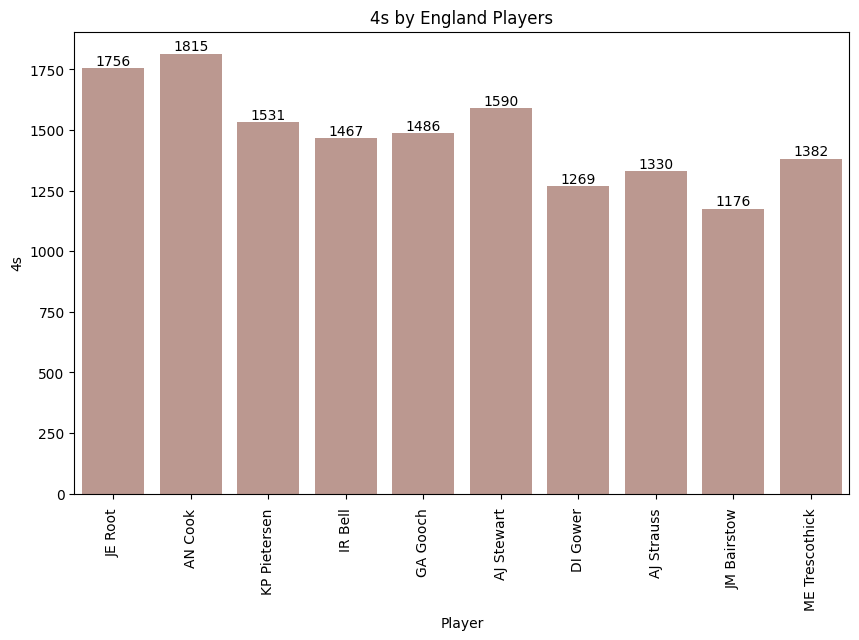

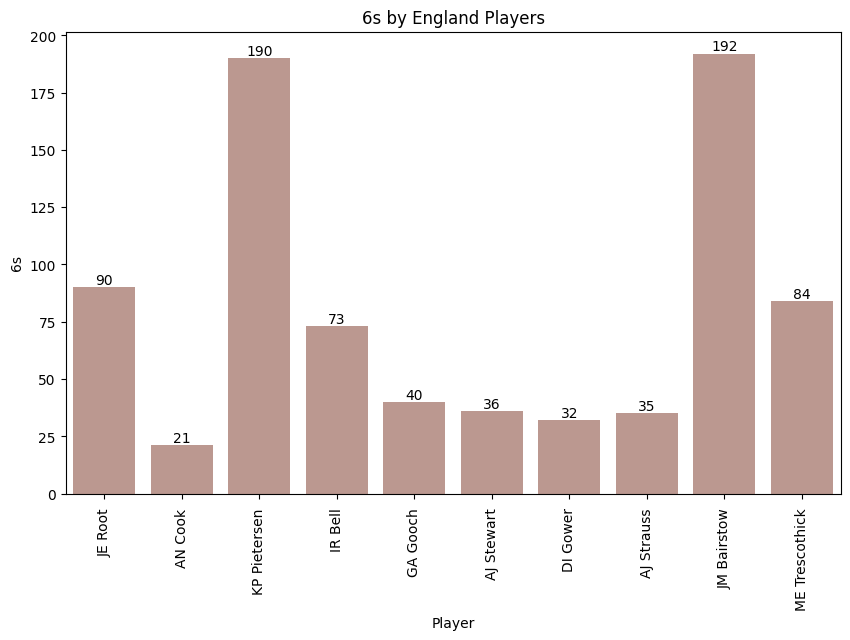

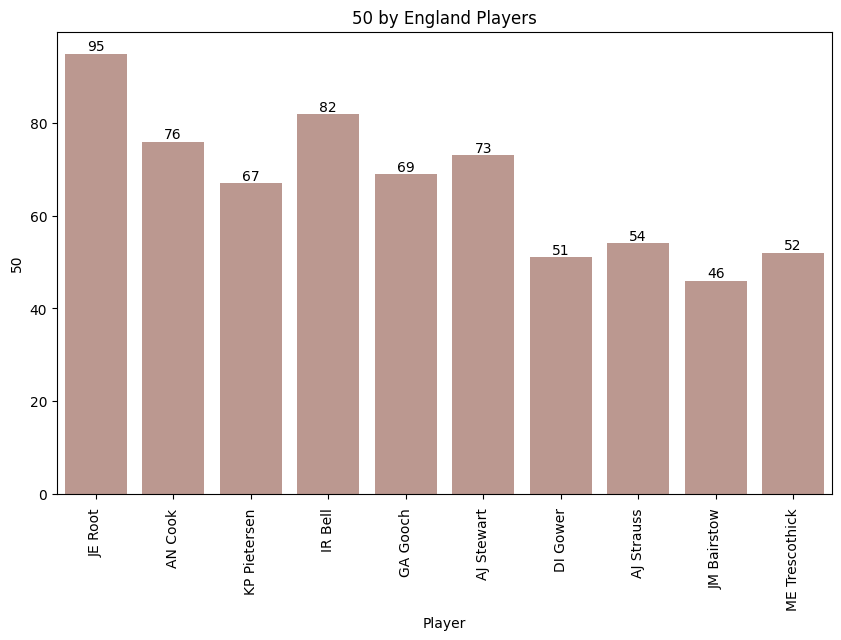

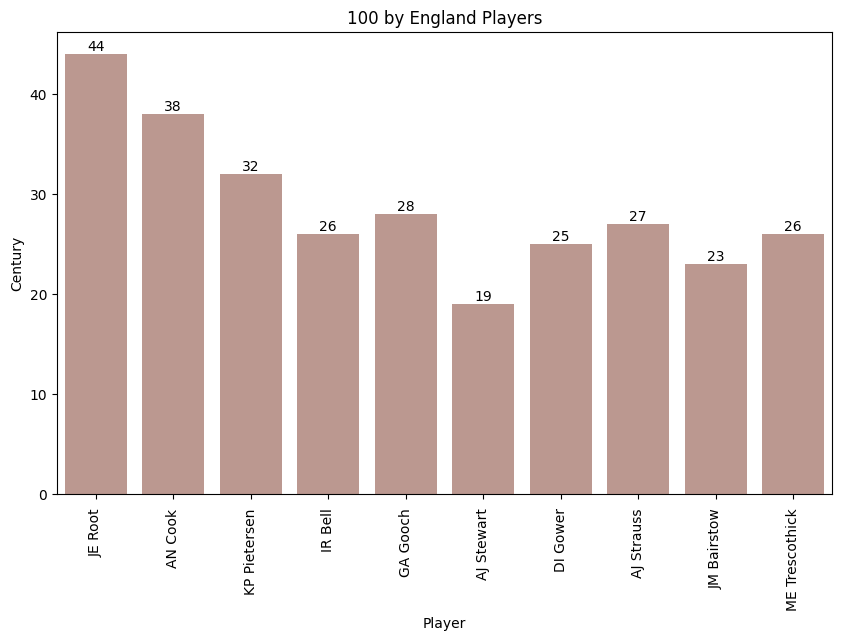

In [25]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=eng["Player"], y=eng["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by England Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=eng["Player"], y=eng["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by England Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=eng["Player"], y=eng["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by England Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=eng["Player"], y=eng["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by England Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **Bangladesh**

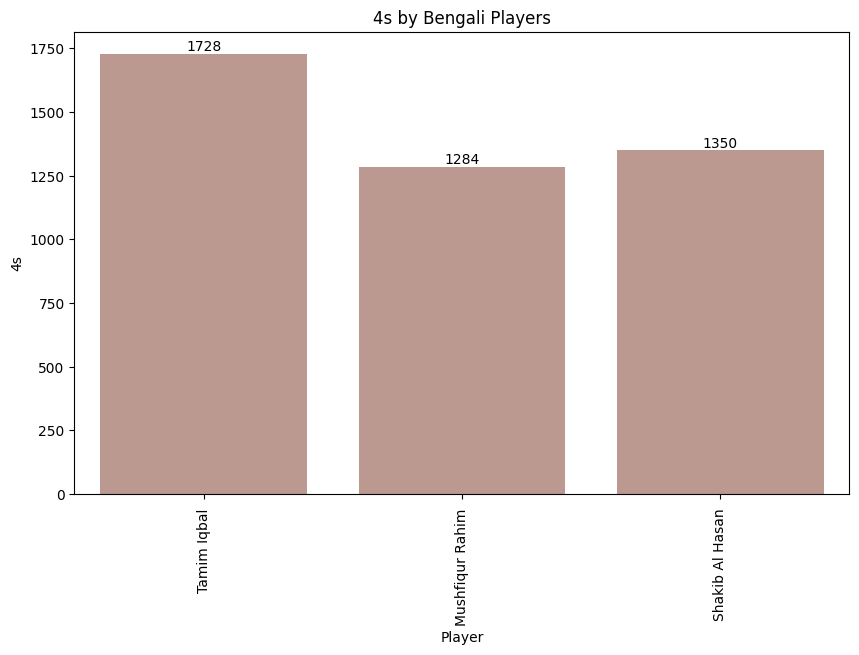

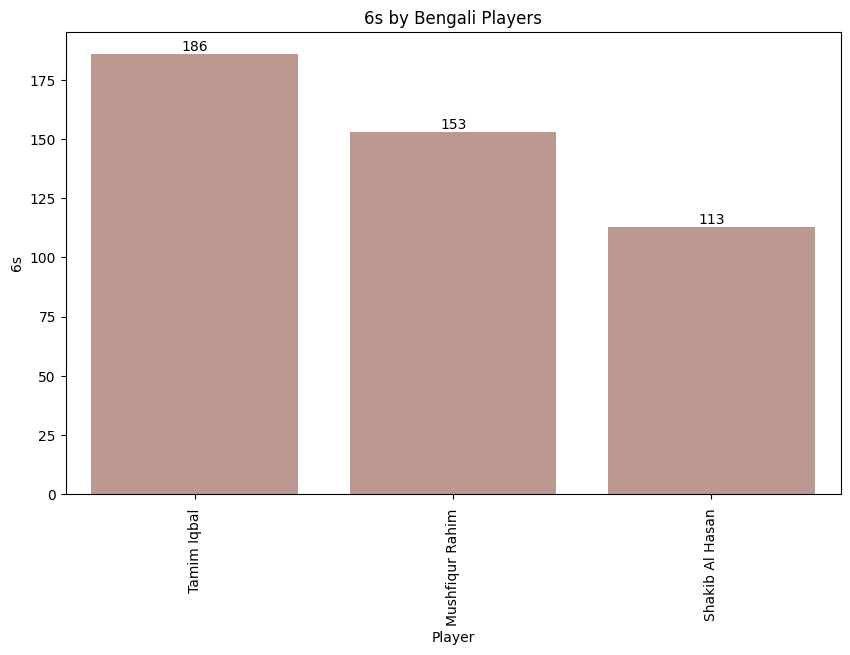

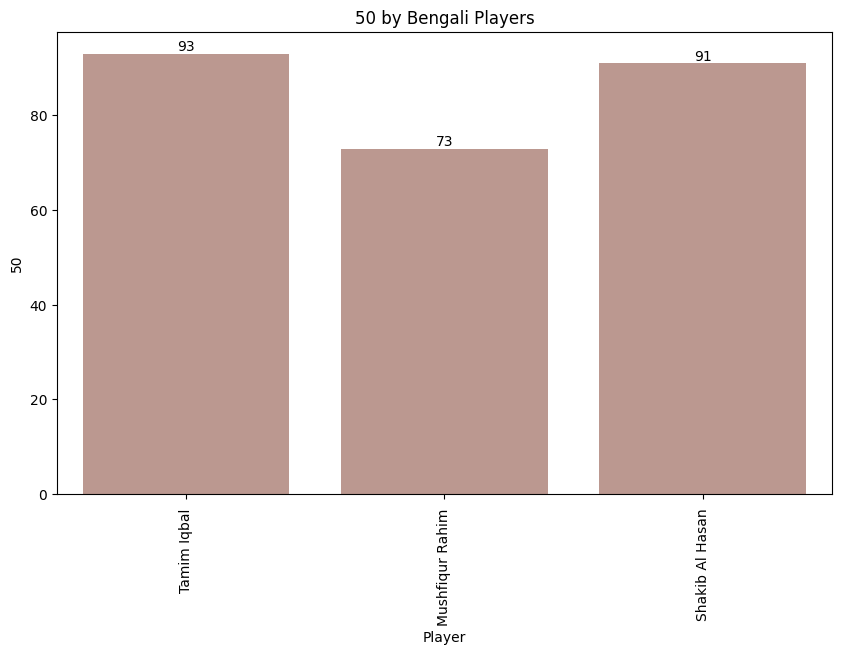

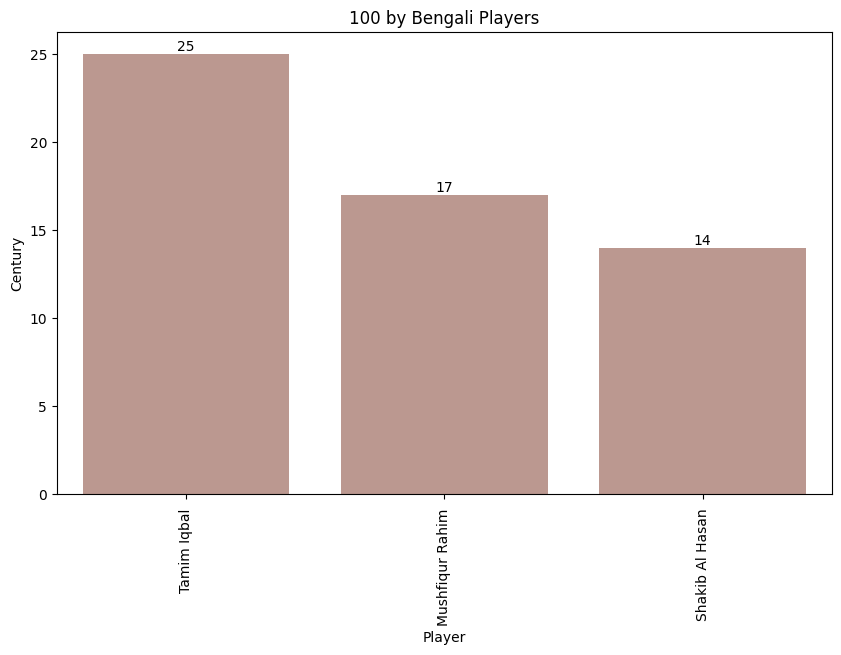

In [26]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=ban["Player"], y=ban["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by Bengali Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=ban["Player"], y=ban["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by Bengali Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=ban["Player"], y=ban["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by Bengali Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=ban["Player"], y=ban["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by Bengali Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **Zimbabwe**

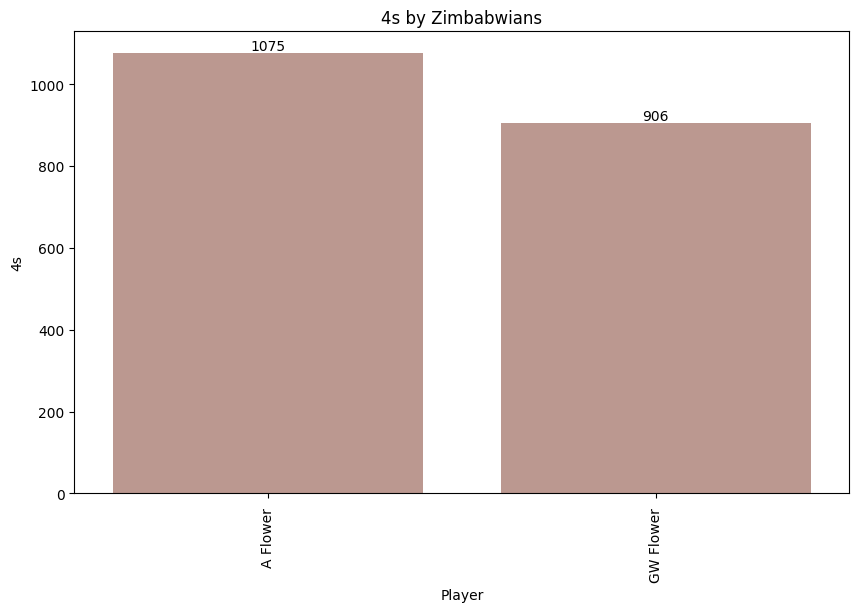

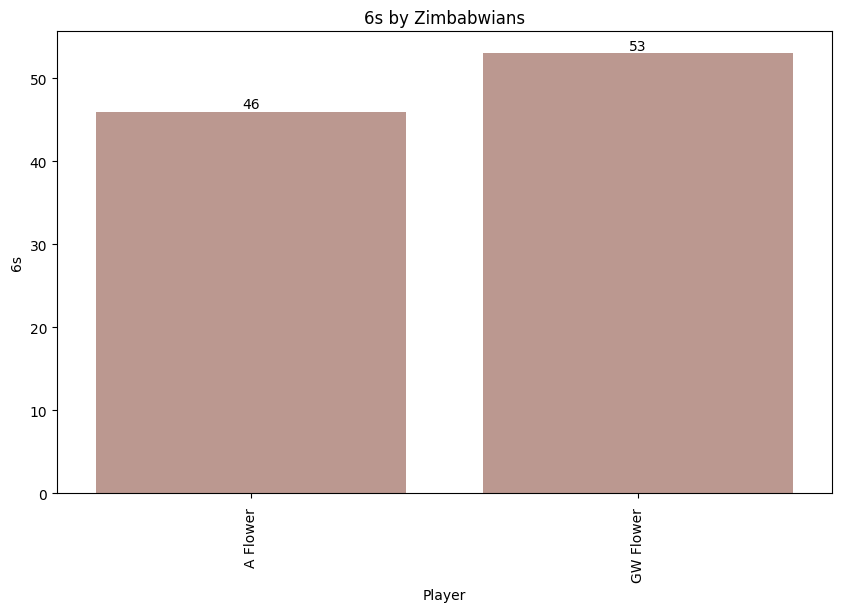

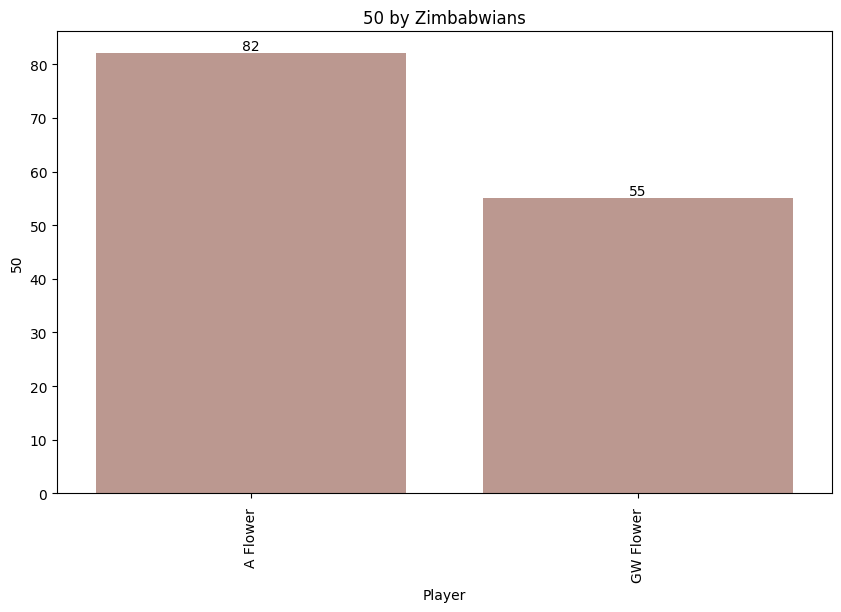

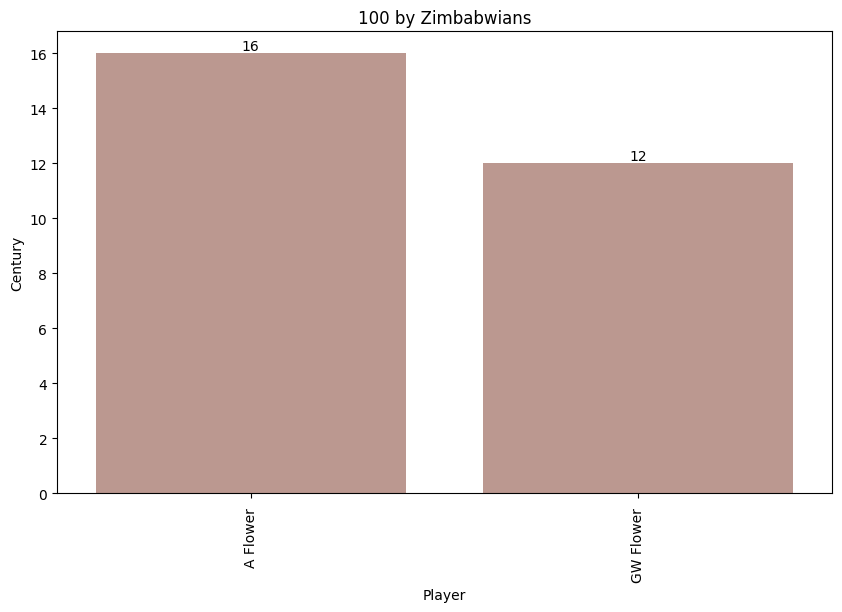

In [27]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=zb["Player"], y=zb["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by Zimbabwians")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=zb["Player"], y=zb["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by Zimbabwians")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=zb["Player"], y=zb["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by Zimbabwians")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=zb["Player"], y=zb["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by Zimbabwians")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

# **Ireland**

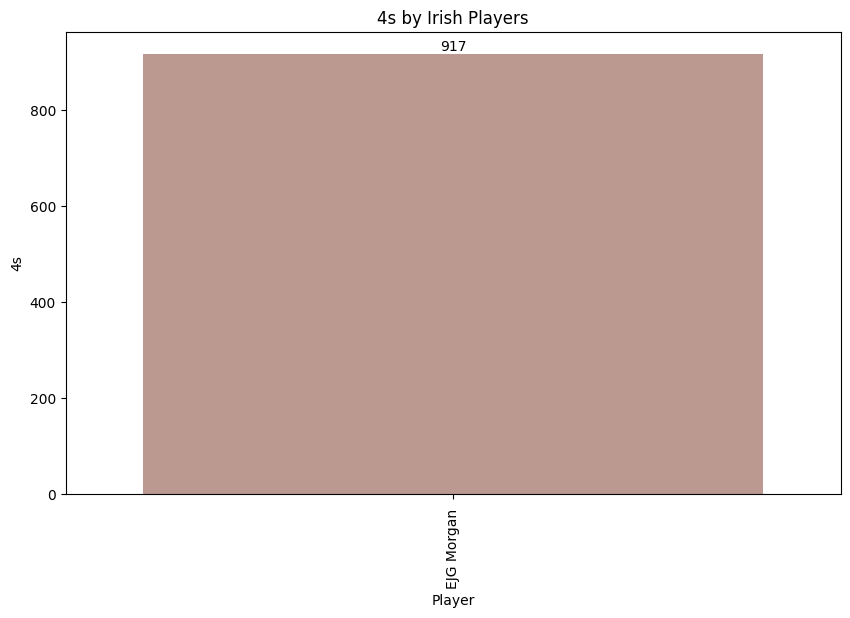

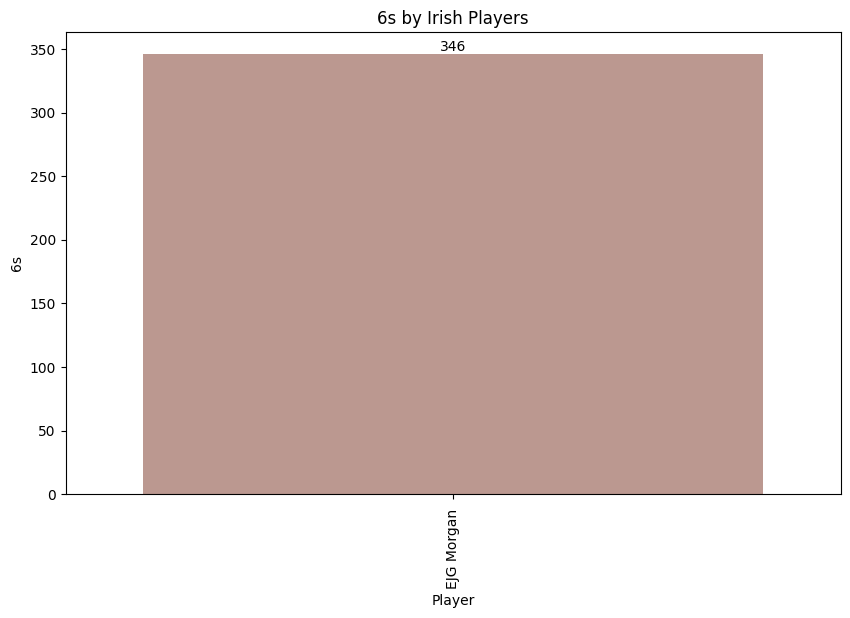

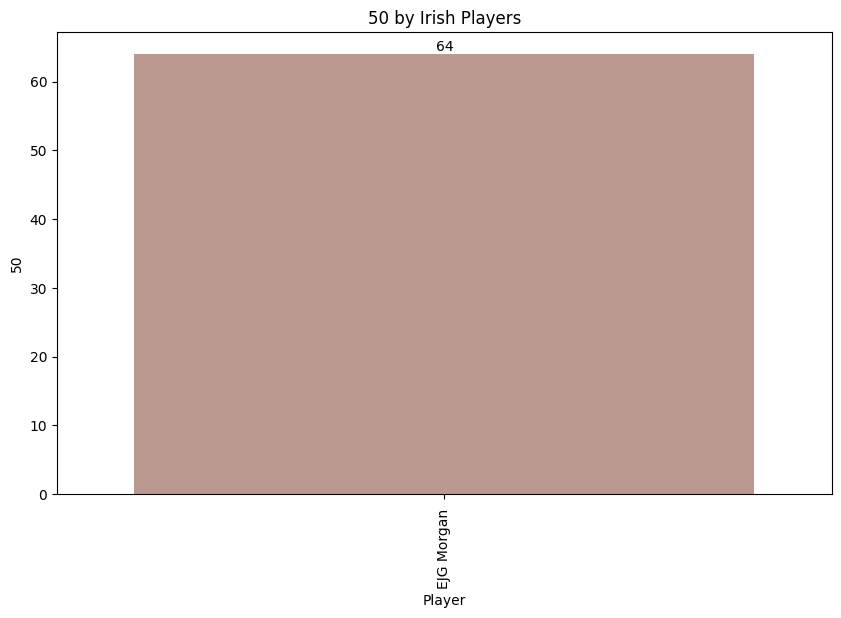

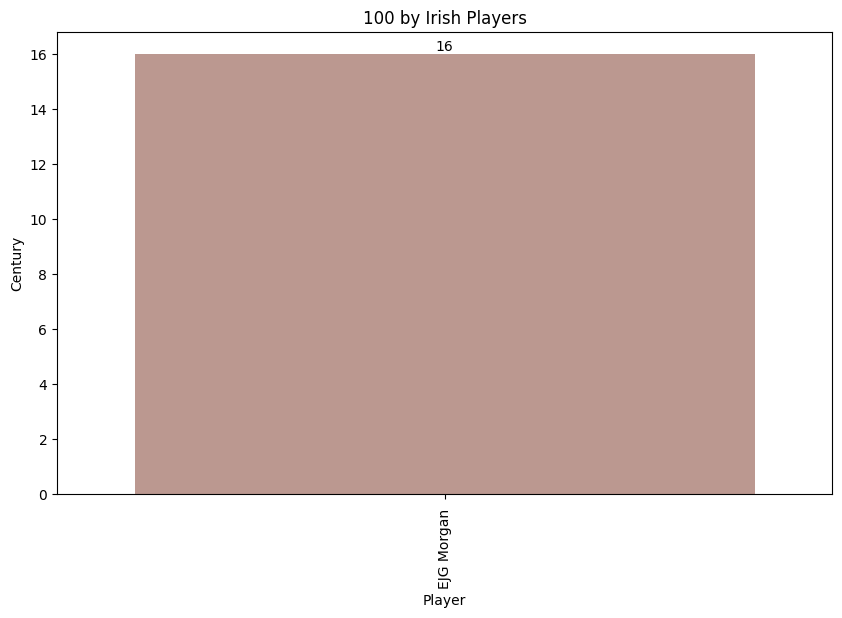

In [28]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=ire["Player"], y=ire["4s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("4s by Irish Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=ire["Player"], y=ire["6s"], color=palette[0])
plt.xticks(rotation=90)
plt.title("6s by Irish Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=ire["Player"], y=ire["50"], color=palette[0])
plt.xticks(rotation=90)
plt.title("50 by Irish Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

plt.figure(figsize=(10,6))
ax = sns.barplot(x=ire["Player"], y=ire["Century"], color=palette[0])
plt.xticks(rotation=90)
plt.title("100 by Irish Players")
for container in ax.containers:
    ax.bar_label(container)
plt.show();

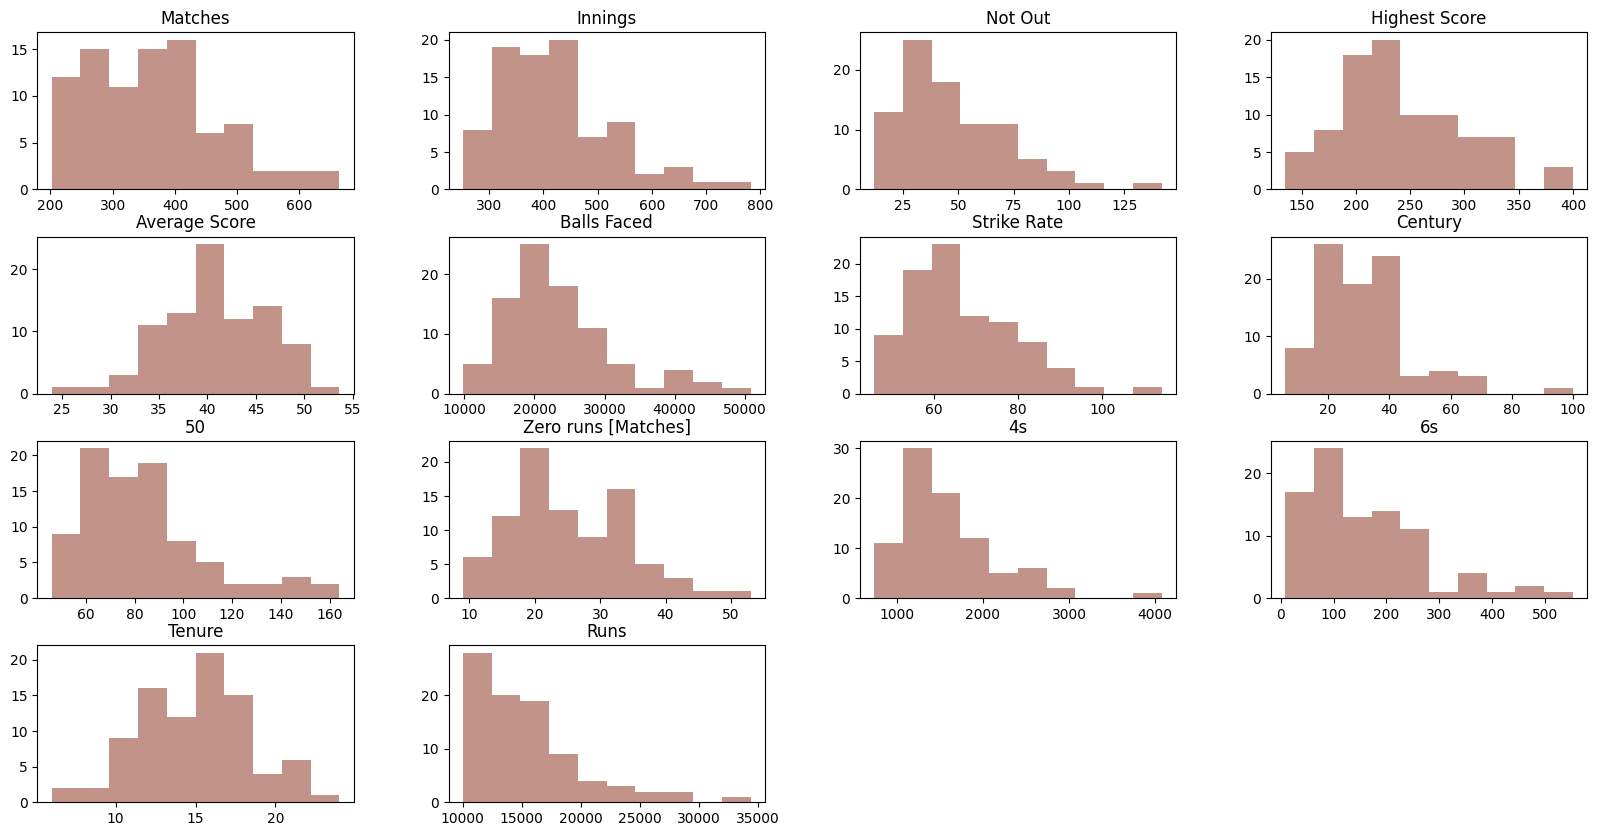

In [29]:
df.iloc[:, 2:].hist(figsize=(20, 10), grid=False, color="#C29389");

# **Feature Engineering**

In [55]:
def feature_eng(df):
    df["Avg_Scr/Year"] = (df["Runs"] / df["Tenure"]).astype(int)
    df["Avg_100/Year"] = (df["Century"] / df["Tenure"]).round(2)
    df["Avg_50/Year"] = (df["50"] / df["Tenure"]).round(2)
    df["Avg_4s/Year"] = (df["4s"] / df["Tenure"]).round(2)
    df["Avg_6s/Year"] = (df["6s"] / df["Tenure"]).round(2)
    df = df.drop(columns=['Player', 'Country', 'Not Out', 'Highest Score',
                          'Average Score','Strike Rate','Zero runs [Matches]', 
                          '6s', 'Tenure'])
    return df 

In [56]:
df = feature_eng(df)

In [57]:
df.head()

Matches  Innings  Balls Faced  Century   50    4s   Runs  Avg_Scr/Year  \
1      594      666        42086       63  153  3015  28016          1867   
2      560      668        40130       71  146  2781  27483          1616   
3      652      725        40100       54  136  2679  25957          1442   
4      519      617        45346       62  149  2455  25534          1343   
5      509      605        46564       48  146  2604  24208          1513   

   Avg_100/Year  Avg_50/Year  Avg_4s/Year  Avg_6s/Year  
1          4.20        10.20       201.00        10.60  
2          4.18         8.59       163.59        14.47  
3          3.00         7.56       148.83         9.44  
4          3.26         7.84       129.21        13.37  
5          3.00         9.12       162.75         4.12

In [58]:
df.describe().T

count          mean          std       min        25%       50%  \
Matches        87.0    362.000000    99.608770    202.00    285.500    360.00   
Innings        87.0    417.183908   100.263087    252.00    337.000    410.00   
Balls Faced    87.0  22958.574713  7520.946623   9809.00  18223.000  21294.00   
Century        87.0     30.241379    13.607424      6.00     20.000     28.00   
50             87.0     82.655172    23.561314     46.00     66.500     76.00   
4s             87.0   1564.827586   480.259407    737.00   1239.000   1467.00   
Runs           87.0  15082.252874  4212.514126  10028.00  11679.000  13936.00   
Avg_Scr/Year   87.0   1053.724138   301.909184    508.00    818.500   1035.00   
Avg_100/Year   87.0      2.143678     0.999804      0.40      1.420      2.06   
Avg_50/Year    87.0      5.782759     1.710016      2.32      4.500      5.58   
Avg_4s/Year    87.0    110.228161    36.864345     46.06     83.675    106.79   
Avg_6s/Year    87.0     10.710690     7.132757      0.56      5.295      9.05   

                    75%       max  
Matches         422.000    652.00  
Innings         464.000    725.00  
Balls Faced   26316.000  46564.00  
Century          38.000     71.00  
50               93.000    153.00  
4s             1763.000   3015.00  
Runs          17259.500  28016.00  
Avg_Scr/Year   1261.500   1867.00  
Avg_100/Year      2.875      5.07  
Avg_50/Year       6.795     10.57  
Avg_4s/Year     133.555    230.33  
Avg_6s/Year      14.615     32.80

<Axes: >

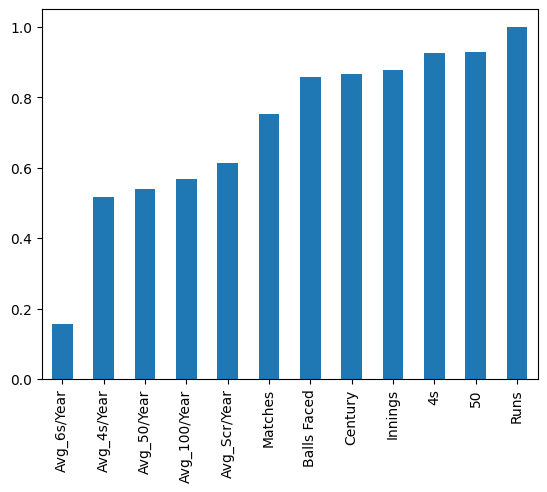

In [64]:
corr = df.corr()
#sns.heatmap(corr, annot=True)

corr["Runs"].sort_values().plot(kind="bar")

In [68]:
df = df.drop(columns="Avg_6s/Year")

# **Removing Outliers**

### **Plotting Outliers**

In [69]:
df.columns

Index(['Matches', 'Innings', 'Balls Faced', 'Century', '50', '4s', 'Runs',
       'Avg_Scr/Year', 'Avg_100/Year', 'Avg_50/Year', 'Avg_4s/Year'],
      dtype='object')

In [70]:
df.shape

(87, 11)

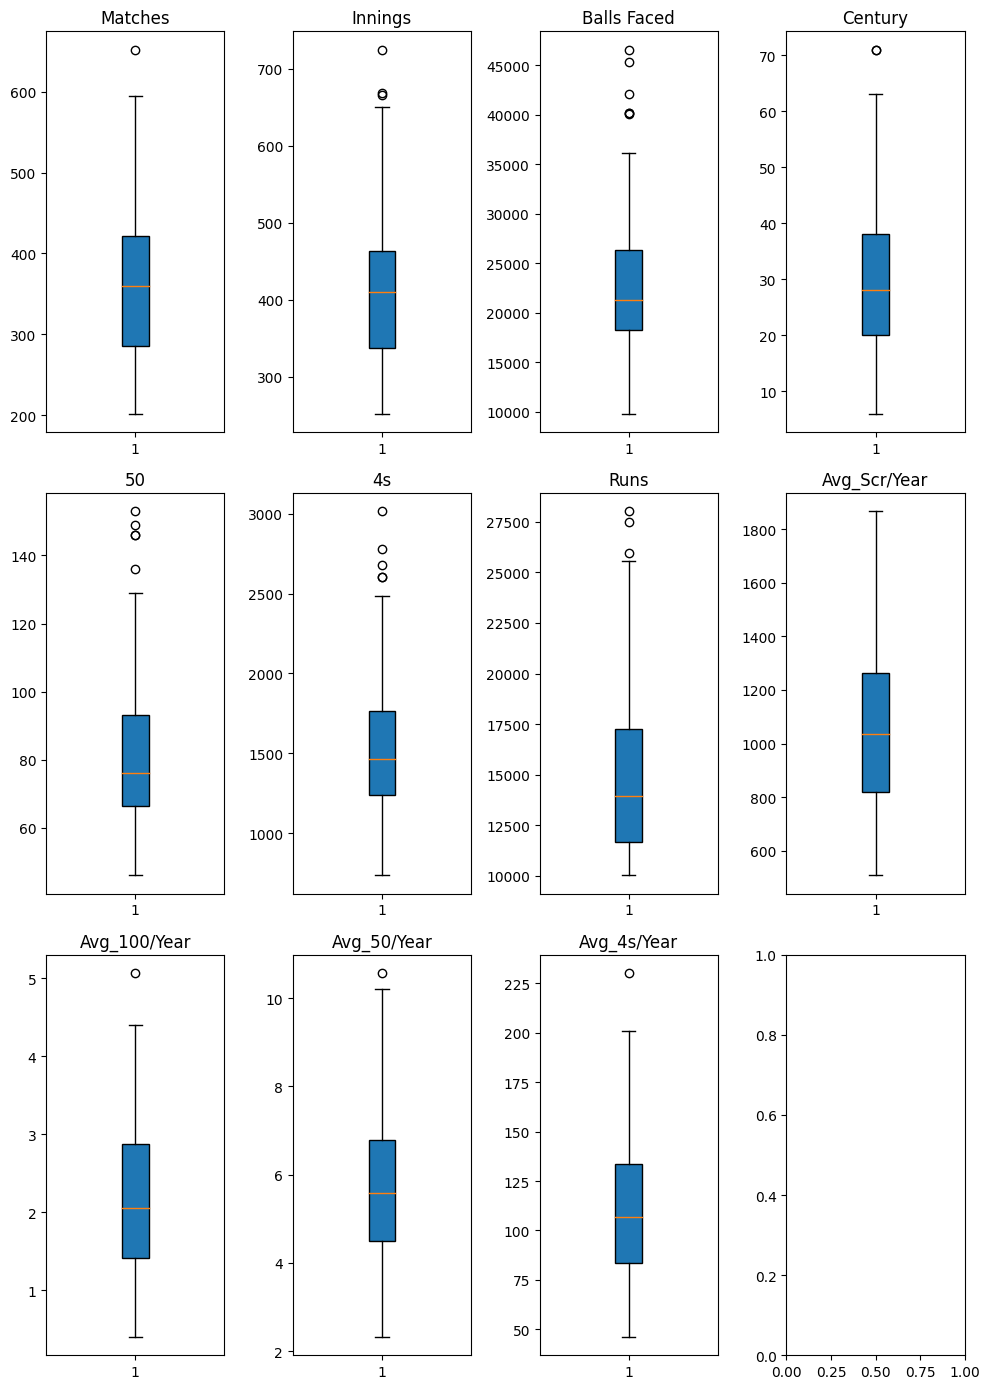

In [72]:
fig, axes = plt.subplots(3, 4, figsize=(10, 14))
axes = axes.flatten()

columns = ['Matches', 'Innings', 'Balls Faced', 'Century', '50', '4s', 'Runs',
       'Avg_Scr/Year', 'Avg_100/Year', 'Avg_50/Year', 'Avg_4s/Year']

for i, col in enumerate(columns):
    ax = axes[i]
    ax.boxplot(df[col], vert=True, patch_artist=True)
    ax.set_title(col)
plt.tight_layout()
plt.show()


In [ ]:
df.shape

In [73]:
cols = df.columns
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.30)
        Q3 = df[col].quantile(0.70)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

    return df
df = remove_outliers(df, cols)
df.shape

(69, 11)

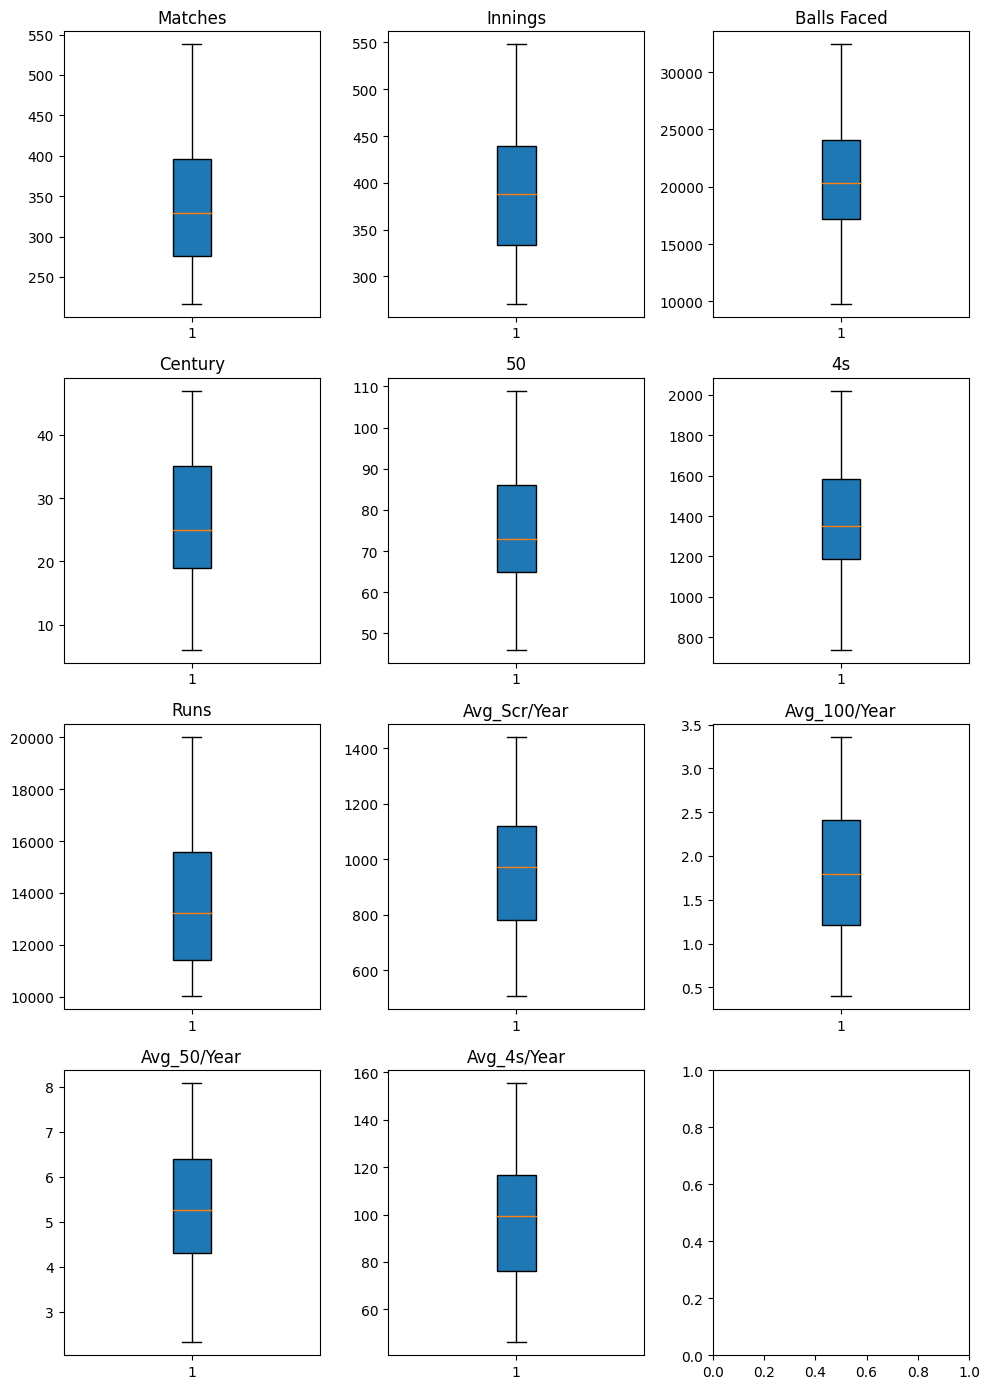

In [75]:
fig, axes = plt.subplots(4, 3, figsize=(10, 14))
axes = axes.flatten()


for i, col in enumerate(df.columns):
    ax = axes[i]
    ax.boxplot(df[col], vert=True, patch_artist=True)
    ax.set_title(col)
plt.tight_layout()
plt.show()


In [76]:
# vertical split into target and feature varibales
y = df["Runs"]
X = df.drop(columns=["Runs"])
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train{X_train.shape}")
print(f"Shape of y_train{y_train.shape}")
print(f"Shape of X_test{X_test.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train(55, 10)
Shape of y_train(55,)
Shape of X_test(14, 10)
Shape of y_test(14,)


# **Feature Scaling**

In [77]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
model = Sequential()

model.add(Dense(5024, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1),input_dim=10))

model.add(Dense(2048, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)))

model.add(Dense(1024, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="Adam", loss="mae")

history = model.fit(X_train, y_train, batch_size=25, epochs=200, validation_split=0.2)

Epoch 1/200
2/2 [==============================] - 2s 423ms/step - loss: 13591.0654 - val_loss: 14398.9629
Epoch 2/200
2/2 [==============================] - 0s 245ms/step - loss: 13519.0127 - val_loss: 14334.3281
Epoch 3/200
2/2 [==============================] - 0s 206ms/step - loss: 13456.1943 - val_loss: 14278.0508
Epoch 4/200
2/2 [==============================] - 0s 216ms/step - loss: 13401.2021 - val_loss: 14228.2021
Epoch 5/200
2/2 [==============================] - 0s 221ms/step - loss: 13351.5967 - val_loss: 14180.6084
Epoch 6/200
2/2 [==============================] - 1s 295ms/step - loss: 13301.5283 - val_loss: 14128.7900
Epoch 7/200
2/2 [==============================] - 0s 247ms/step - loss: 13240.7617 - val_loss: 14058.7354
Epoch 8/200
2/2 [==============================] - 0s 248ms/step - loss: 13153.8184 - val_loss: 13949.1240
Epoch 9/200
2/2 [==============================] - 0s 250ms/step - loss: 13017.7383 - val_loss: 13771.5967
Epoch 10/200
2/2 [===================

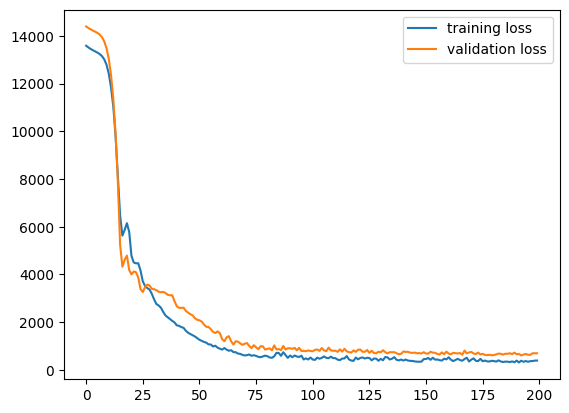

In [84]:
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()

In [85]:
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))
print(r2_score(y_pred, y_test))

1/1 [==============================] - 0s 113ms/step
271.32840401785717
0.9849653800485907


In [86]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(mean_absolute_error(y_pred, y_test))
print(r2_score(y_pred, y_test))

119.491316695072
0.996384131592612


# **Work In Progress**